# 1. Problem formulation

a) This project intends to make a dependency between inflation and unemployment. In economics this dependency is known as "Phillips curve". Based on the data from 10 countries around the world we will try to analise whether this economics law reflects reality.

b) Creating a model will help us determine whether one can rely on the widely acclaimed Phillips curve. The potential use cases include prediction of unemployment at a certain level of CPI indicator (iflation indicator) or vice versa.

c) The data we use is downloaded from OECD website (The Organisation for Economic Co-operation and Development). It contains levels of unemployment and inflation of 10 countries all around the world: Poland, Hungary, Czech Republic, Germany, Spain, France, USA, Canada, Chile and Japan. 

d) The data comes from as many years as there is available for a given country and usually it is a different period for inflation and unemployment. Hence, the data has to be preprocessed before we can make use of it.
From the dataset we extract data for the desired countries and for each country we take a period which is common for inflation and unemployment.

In [1]:
from cmdstanpy import CmdStanModel
import arviz as az
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

# Model

a) For this research, 2 models were chosen: linear and hyperbolic.

b) Difference between these two models should be obvious to anyone, who finished secondary school math course
The linear model assumes that there may be a simple, linear relationship between inflation and unemployment.
The hyperbolic model, on the other hand, allows us to model a curve similar to the Phillips curve.

c) Models differ especially for changes where unemployment is small - in hyperbolic model minor change in unemployment causes large change in inflation. In linear model it does not matter.

d) Linear model was chosen to check if Phillips curve exists at all. Hyperbolic, on the other hand, may be found in literature concerning the issue, i.e.
A. W. PHILLIPS, 'The Relation Between Unemployment and the Rate
of Change of Money Wage Rates in the
United Kingdom, 1861-1957’

Linear model includes two varying parameters, a and b. Its formula is ax + b
Hyperbolic model includes three varying parameters, a, b and c. Its formula is a/(x^b) + c
Both models require data with inflation and unemployment

In [2]:
stan_file_linear = r"C:\Studia\Data-Analytics\Projekt-Proper\Inflation_model_linear.stan"
model_linear = CmdStanModel(stan_file=stan_file_linear)

INFO:cmdstanpy:found newer exe file, not recompiling


In [3]:
stan_file_phillips = r"C:\Studia\Data-Analytics\Projekt-Proper\Inflation_model_phillips.stan"
model_phillips = CmdStanModel(stan_file=stan_file_phillips)

INFO:cmdstanpy:found newer exe file, not recompiling


In [4]:
#Translates a string in a form of yyyy-mm to a date
def translate_date(string: str):
    date = string.split("-")
    return datetime.date(int(date[0]), int(date[1]), 1)

def translate_all(dataframe):
    for i in range(len(dataframe)):
        dataframe.loc[i, "TIME"] = translate_date(dataframe.loc[i, "TIME"])
    return dataframe

def truncate_dates(inflation_df, unemployment_df):
    inflation_date_start = inflation_df["TIME"][:1].values[0]
    unemployment_date_start = unemployment_df["TIME"][:1].values[0]
    inflation_date_end = inflation_df["TIME"][-1:].values[0]
    unemployment_date_end = unemployment_df["TIME"][-1:].values[0]

    # print("inflation dates: " + str(inflation_date_start) + " - " + str(inflation_date_end))
    # print("unemployment dates: " + str(unemployment_date_start) + " - " + str(unemployment_date_end))


    if inflation_date_start > unemployment_date_start:
        unemployment_df = unemployment_df.loc[unemployment_df["TIME"] >= inflation_date_start]
    else:
        inflation_df = inflation_df.loc[inflation_df["TIME"] >= unemployment_date_start]
    
    if inflation_date_end < unemployment_date_end:
        unemployment_df = unemployment_df.loc[unemployment_df["TIME"] <= inflation_date_end]
    else:
        inflation_df = inflation_df.loc[inflation_df["TIME"] <= unemployment_date_end]

    return [inflation_df, unemployment_df]



inflation = pd.read_csv("inflacja.csv")
inflation = translate_all(inflation)

unemployment = pd.read_csv("unemployment.csv")
unemployment = translate_all(unemployment)

In [5]:
def sample_models(country, span, span_start_idx, model1, model2):
    # 1 month = 1 sample
    infl_value = np.array(country[0]["Value"][span_start_idx:span_start_idx + span])
    unemp_value = np.array(country[1]["Value"][span_start_idx:span_start_idx + span])
    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    data = {
    "N": span,
    "x": comp[1, :],
    "y": comp[0, :]
    }

    fit1 = model1.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    fit2 = model2.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    return fit1, fit2    

In [6]:
def concatenate_all_data(country_list):
    infl_value_all = np.array([])
    unemp_value_all = np.array([])
    for country in country_list:
        infl_value = np.array(country[0]["Value"][:])
        unemp_value = np.array(country[1]["Value"][:])
        infl_value_all = np.append(infl_value, infl_value_all)
        unemp_value_all = np.append(unemp_value, unemp_value_all)
    comp = np.array([infl_value_all, unemp_value_all]).T
    comp = comp[comp[:, 1].argsort()].T
    return comp

In [7]:
def plot_results(country, fit1, fit2, span_start_idx, span):

    infl_value = np.array(country[0]["Value"][span_start_idx:span_start_idx + span])
    unemp_value = np.array(country[1]["Value"][span_start_idx:span_start_idx + span])

    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    df1 = fit1.draws_pd()
    df2 = fit2.draws_pd()

    time = country[0]["TIME"][span_start_idx:span_start_idx + span]

    model1_med5 = np.zeros(span)
    model1_med50 = np.zeros(span)
    model1_med95 = np.zeros(span)
    model2_med5 = np.zeros(span)
    model2_med50 = np.zeros(span)
    model2_med95 = np.zeros(span)
    model1_data_idx = 10
    model2_data_idx = 11
    lin_params = ["alpha", "beta", "sigma"]
    phil_params = ["alpha", "beta", "gamma", "sigma"]
    country_name = country[0].iloc[0, 0]

    for i in range(span):
        model1_med5[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.05)
        model1_med50[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.5)
        model1_med95[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.95)
        model2_med5[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.05)
        model2_med50[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.5)
        model2_med95[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.95)

    fig, axis = plt.subplots(1, 4, figsize=(28, 6))
    axis[0].plot(time, infl_value)
    axis[0].plot(time, unemp_value)
    axis[0].legend(["Inflation", "Unemployment"])
    axis[0].set_title(country_name + " ")

    axis[1].plot(comp[1, :], comp[0, :], 'o')
    axis[1].set_xlabel("Unemployment", fontsize=14)
    axis[1].set_ylabel("Inflation", fontsize=14)
    axis[1].plot(comp[1, :], model1_med5, '#8B0000', linewidth=1.75)
    axis[1].plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    axis[1].plot(comp[1, :], model1_med95, '#FF0000', linewidth=1.75)
    axis[1].legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[1].set_title(country_name + " Linear ")


    axis[2].plot(comp[1, :], comp[0, :], 'o')
    axis[2].set_xlabel("Unemployment", fontsize=14)
    axis[2].set_ylabel("Inflation", fontsize=14)
    axis[2].plot(comp[1, :], model2_med5, '#013220', linewidth=1.75)
    axis[2].plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    axis[2].plot(comp[1, :], model2_med95, '#00FF00', linewidth=1.75)
    axis[2].legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[2].set_title(country_name + " Phillips curve")


    axis[3].plot(comp[1, :], comp[0, :], 'o')
    axis[3].set_xlabel("Unemployment", fontsize=14)
    axis[3].set_ylabel("Inflation", fontsize=14)
    axis[3].plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    axis[3].plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    axis[3].legend(["Real data", "quantile 50% linear", "quantile 50% phillips"])
    axis[3].set_title("Model comparison")

    _, axis = plt.subplots(1, 3, figsize = (21, 6))
    for j, param in enumerate(lin_params):
        axis[j].hist(fit1.stan_variable(param), bins = 15, edgecolor='k')
        axis[j].set_title(param)
    plt.show()

    fig, axis = plt.subplots(1, 4, figsize = (28, 6))
    for j, param in enumerate(phil_params):
        axis[j].hist(fit2.stan_variable(param), bins = 15, edgecolor='k')
        axis[j].set_title(param)
    plt.show()

    arviz_fit1 = az.from_cmdstanpy(fit1, log_likelihood='log_lik', posterior_predictive='y_hat')
    arviz_fit2 = az.from_cmdstanpy(fit2, log_likelihood='log_lik', posterior_predictive='y_hat')
    arviz_dict = dict(arviz_fit1 = arviz_fit1, arviz_fit2 = arviz_fit2)

    loo = az.compare(arviz_dict, 'loo')
    az.plot_compare(loo)

    waic = az.compare(arviz_dict, 'waic')
    az.plot_compare(waic)
    display(loo)
    display(waic)

In [8]:
def plot_results_all_data(country, fit1, fit2, fig_nr, span):
    infl_value = country[0]
    unemp_value = country[1]

    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    df1 = fit1.draws_pd()
    df2 = fit2.draws_pd()

    model1_med5 = np.zeros(span)
    model1_med50 = np.zeros(span)
    model1_med95 = np.zeros(span)
    model2_med5 = np.zeros(span)
    model2_med50 = np.zeros(span)
    model2_med95 = np.zeros(span)
    model1_data_idx = 10
    model2_data_idx = 11
    lin_params = ["alpha", "beta", "sigma"]
    phil_params = ["alpha", "beta", "gamma", "sigma"]
    country_name = 'All countries'

    for i in range(span):
        model1_med50[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.05)
        model1_med50[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.5)
        model1_med95[i] = np.quantile(df1.iloc[:, i + model1_data_idx], 0.95)
        model2_med50[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.05)
        model2_med50[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.5)
        model2_med95[i] = np.quantile(df2.iloc[:, i + model2_data_idx], 0.95)


    fig, axis = plt.subplots(1, 3, figsize=(21, 6))
    axis[0].plot(comp[1, :], comp[0, :], 'o')
    axis[0].set_xlabel("Unemployment", fontsize=14)
    axis[0].set_ylabel("Inflation", fontsize=14)
    axis[0].plot(comp[1, :], model1_med5, '#8B0000', linewidth=1.75)
    axis[0].plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    axis[0].plot(comp[1, :], model1_med95, '#FF0000', linewidth=1.75)
    axis[0].legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[0].set_title(country_name + " Linear ")


    axis[1].plot(comp[1, :], comp[0, :], 'x')
    axis[1].set_xlabel("Unemployment", fontsize=14)
    axis[1].set_ylabel("Inflation", fontsize=14)
    axis[1].plot(comp[1, :], model2_med5, '#013220', linewidth=1.75)
    axis[1].plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    axis[1].plot(comp[1, :], model2_med95, '#00FF00', linewidth=1.75)
    axis[1].legend(["Real data", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[1].set_title(country_name + " Phillips curve")


    axis[2].plot(comp[1, :], comp[0, :], 'x')
    axis[2].set_xlabel("Unemployment", fontsize=14)
    axis[2].set_ylabel("Inflation", fontsize=14)
    axis[2].plot(comp[1, :], model1_med50, '#DC143C', linewidth=1.75)
    axis[2].plot(comp[1, :], model2_med50, '#32CD32', linewidth=1.75)
    axis[2].legend(["Real data", "quantile 50% linear", "quantile 50% phillips"])
    axis[2].set_title("Model comparison")

    _, axes = plt.subplots(1, 3, figsize = (21, 6))
    for j, param in enumerate(lin_params):
        axes[j].hist(fit1.stan_variable(param), bins = 15, edgecolor='k')
        axes[j].set_title(param)
    plt.show()

    _, axes = plt.subplots(1, 4, figsize = (28, 6))
    for j, param in enumerate(phil_params):
        axes[j].hist(fit2.stan_variable(param), bins = 15, edgecolor='k')
        axes[j].set_title(param)
    plt.show()

In [9]:
def sample_models_all_data(country, span, span_start_idx, model1, model2):
    # 1 month = 1 sample
    infl_value = country[0]
    unemp_value = country[1]
    comp = np.array([infl_value, unemp_value]).T
    comp = comp[comp[:, 1].argsort()].T

    data = {
    "N": span,
    "x": comp[1, :],
    "y": comp[0, :]
    }

    fit1 = model1.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    fit2 = model2.sample(data = data, iter_sampling = 1000, iter_warmup=500)
    return fit1, fit2

In [10]:
def plot_prior(df_prior):
    y_lin_05 = np.array([])
    y_lin_50 = np.array([])
    y_lin_95 = np.array([])
    y_phil_05 = np.array([])
    y_phil_50 = np.array([])
    y_phil_95 = np.array([])
    for i in range(1, 1001):
        y_lin_05 = np.append(y_lin_05, np.quantile(df_prior.loc[:, "y_l[" + str(i) + "]"], 0.05))
        y_lin_50 = np.append(y_lin_50, np.quantile(df_prior.loc[:, "y_l[" + str(i) + "]"], 0.5))
        y_lin_95 = np.append(y_lin_95, np.quantile(df_prior.loc[:, "y_l[" + str(i) + "]"], 0.95))
        y_phil_05 = np.append(y_phil_05, np.quantile(df_prior.loc[:, "y_p[" + str(i) + "]"], 0.05))
        y_phil_50 = np.append(y_phil_50, np.quantile(df_prior.loc[:, "y_p[" + str(i) + "]"], 0.5))
        y_phil_95 = np.append(y_phil_95, np.quantile(df_prior.loc[:, "y_p[" + str(i) + "]"], 0.95))
        
    x = np.linspace(2, 30, 1000)

    fig, axis = plt.subplots(1, 2, figsize=(16, 8))
    axis[0].plot(x, df_prior.iloc[0, 5:1005], 'o')
    axis[0].plot(x, y_lin_05, 'r')
    axis[0].plot(x, y_lin_50, '#00FF00', linewidth = 2)
    axis[0].plot(x, y_lin_95)
    axis[0].set_xlabel("unemployment")
    axis[0].set_ylabel("inflation")
    axis[0].legend(["Expected data points", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[0].set_title("model 1")

    axis[1].plot(x, df_prior.iloc[0, 1008:2008], 'o')
    axis[1].plot(x, y_phil_05, 'r')
    axis[1].plot(x, y_phil_50, '#00FF00', linewidth = 2)
    axis[1].plot(x, y_phil_95)
    axis[1].set_xlabel("unemployment")
    axis[1].set_ylabel("inflation")
    axis[1].legend(["Expected data points", "quantile 5%", "quantile 50%", "quantile 95%"])
    axis[1].set_title("model 2")

    lin_params = ["alpha_l", "beta_l", "sigma_l"]
    phil_params = ["alpha_p", "beta_p", "gamma", "sigma_p"]

    _, axis = plt.subplots(1, 3, figsize = (21, 6))
    for j, param in enumerate(lin_params):
        axis[j].hist(df_prior.loc[:, param], bins = 15, edgecolor='k')
        axis[j].set_title(param)
    plt.show()


    fig, axis = plt.subplots(1, 4, figsize = (28, 6))
    for j, param in enumerate(phil_params):
        axis[j].hist(df_prior.loc[:, param], bins = 15, edgecolor='k')
        axis[j].set_title(param)
    plt.show()

In [11]:
locations = ["POL", "HUN", "CZE", "DEU", "ESP", "FRA", "USA", "CAN", "CHL", "JPN"]
infl_list = []
unemp_list = []
country_list = []
for count, location in enumerate(locations):
    infl, unemp = truncate_dates(inflation.loc[inflation["LOCATION"] == location], unemployment.loc[unemployment["LOCATION"] == location])
    # infl_list.append(infl)
    # unemp_list.append(unemp)
    country = infl, unemp
    country_list.append(country)

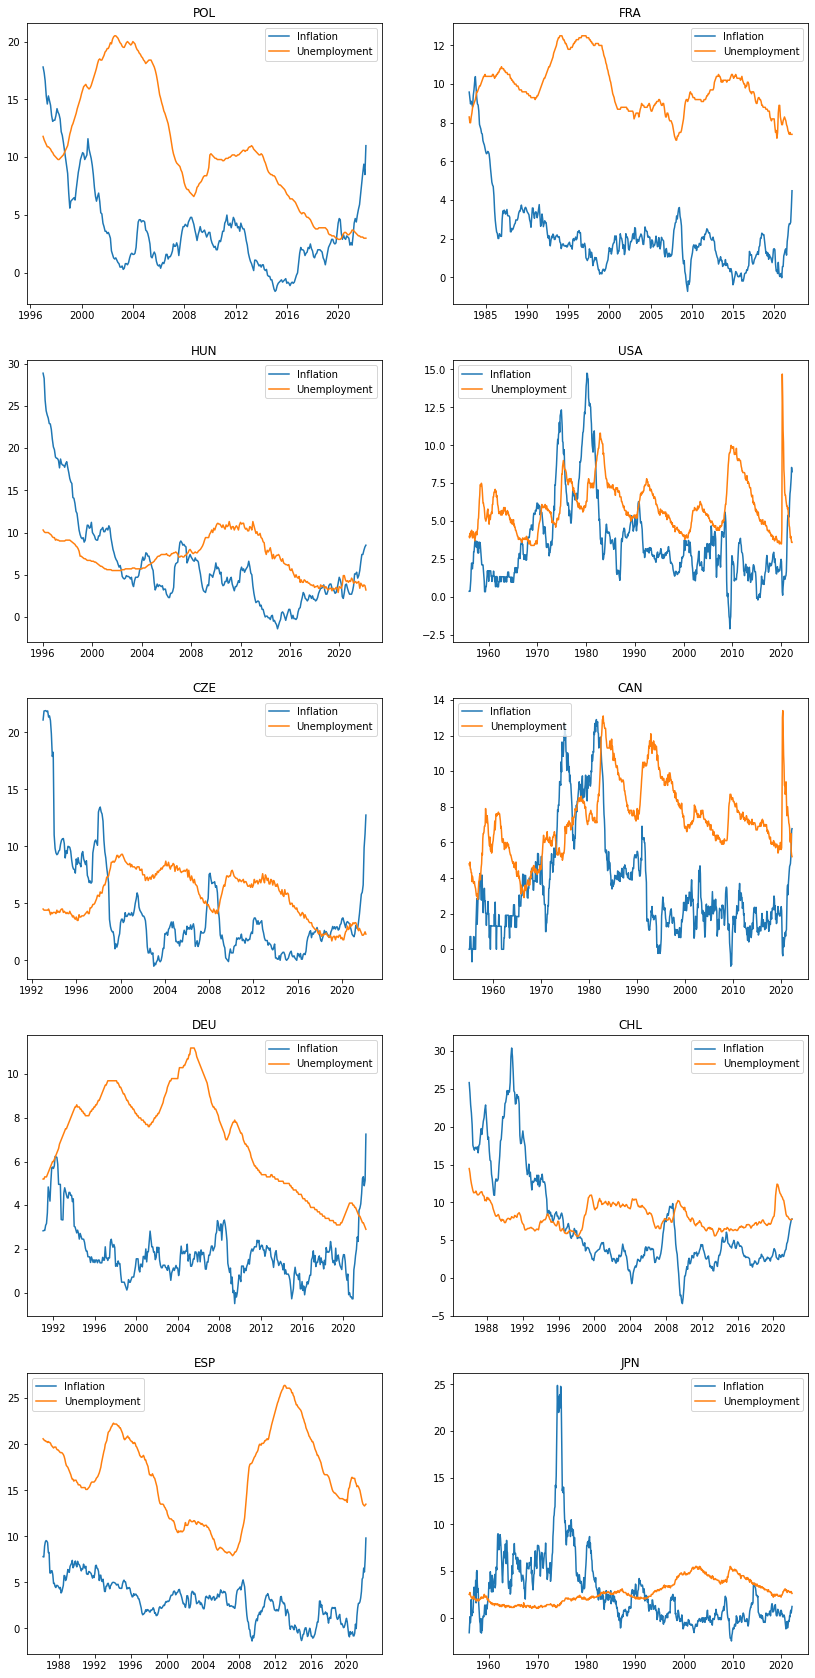

In [12]:
subplt_idx = [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [0, 1], [1, 1], [2, 1], [3, 1], [4, 1]]
fig, axis = plt.subplots(5, 2, figsize=(14, 30))
for i, country in enumerate(country_list):
    axis[subplt_idx[i][0], subplt_idx[i][1]].plot(country[0]["TIME"], country[0]["Value"])
    axis[subplt_idx[i][0], subplt_idx[i][1]].plot(country[1]["TIME"], country[1]["Value"])
    axis[subplt_idx[i][0], subplt_idx[i][1]].legend(["Inflation", "Unemployment"])
    axis[subplt_idx[i][0], subplt_idx[i][1]].set_title(locations[i])

In [13]:
stan_file_prior = r"C:\Studia\Data-Analytics\Projekt-Proper\generated_quantities.stan"
model_prior = CmdStanModel(stan_file=stan_file_prior)

INFO:cmdstanpy:found newer exe file, not recompiling


In [14]:
data = {
"N": 1000,
"x": np.linspace(2, 30, 1000)
}

fit_prior = model_prior.sample(data = data, iter_sampling = 1000, iter_warmup=500)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▏        | 00:00 Iteration:   1 / 1000 [  0%]  (Sampling)




chain 1 |█▊        | 00:00 Iteration: 100 / 1000 [ 10%]  (Sampling)
chain 1 |██▎       | 00:01 Iteration: 200 / 1000 [ 20%]  (Sampling)


chain 1 |██▉       | 00:01 Iteration: 300 / 1000 [ 30%]  (Sampling)


chain 1 |███▌      | 00:01 Iteration: 400 / 1000 [ 40%]  (Sampling)


chain 1 |████      | 00:02 Iteration: 500 / 1000 [ 50%]  (Sampling)

chain 1 |████▋     | 00:02 Iteration: 600 / 1000 [ 60%]  (Sampling)


chain 1 |█████▎    | 00:03 Iteration: 700 / 1000 [ 70%]  (Sampling)


chain 1 |█████▉    | 00:03 Iteration: 800 / 1000 [ 80%]  (Sampling)


chain 1 |██████▍   | 00:03 Iteration: 900 / 1000 [ 90%]  (Sampling)


chain 1 |██████████| 00:04 Sampling completed                      
chain 2 |██████████| 00:04 Sampling completed                      
chain 3 |██████████| 00:04 Sampling completed                      
chain 4 |██████████|


INFO:cmdstanpy:CmdStan done processing.


In [16]:
df_prior = fit_prior.draws_pd()
df_prior

,lp__,accept_stat__,alpha_l,beta_l,sigma_l,y_l[1],y_l[2],y_l[3],y_l[4],y_l[5],...,y_p[991],y_p[992],y_p[993],y_p[994],y_p[995],y_p[996],y_p[997],y_p[998],y_p[999],y_p[1000]
0,0.0,0.0,16.9070,-0.544469,2.22720,17.77250,15.89360,17.71200,17.3684,13.8861,...,3.793370,2.608770,-3.135900,0.758025,4.002910,-2.496820,-3.265130,4.82664,3.533220,4.50051
1,0.0,0.0,16.7753,-0.525228,3.89915,13.65890,20.55480,13.71650,11.8825,13.2486,...,2.526570,-0.065783,13.020100,5.193400,9.079860,-2.624560,5.453480,7.64461,6.999390,-14.25650
2,0.0,0.0,20.6751,-0.509937,1.95721,22.46560,18.17030,19.23990,19.6114,20.6692,...,9.183590,2.112370,-1.334070,-5.458530,3.163650,-1.900290,-1.031390,5.91825,-3.547400,-2.94871
3,0.0,0.0,14.6929,-0.469240,9.22932,4.89795,6.73345,17.07240,18.5169,12.0668,...,7.902720,3.805350,0.444008,-0.036227,6.404770,-3.929410,7.693860,1.34132,1.908340,-1.69986
4,0.0,0.0,19.3092,-0.581953,2.17863,16.39690,20.13580,15.25890,18.8043,18.0433,...,3.371240,3.091000,0.448976,0.608322,1.617340,-3.872030,0.532808,-2.39738,-1.725490,-0.50976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0,0.0,17.9840,-0.581250,5.83678,18.76240,13.90840,26.34820,10.1730,18.8407,...,7.939170,6.635770,3.867180,2.339670,7.369290,-0.501483,4.371700,1.00307,0.126839,7.21179
3996,0.0,0.0,17.0801,-0.573098,5.26532,16.30050,12.81750,4.87403,21.3631,25.9961,...,0.399686,2.184400,1.970740,1.072210,1.144380,1.379280,1.521710,-0.15693,1.849860,1.35429
3997,0.0,0.0,19.5337,-0.617960,2.84240,21.05740,18.14320,18.36630,16.3600,17.4413,...,2.591520,3.134240,3.590690,0.518403,0.777948,0.803407,2.454360,2.19726,1.598370,3.04875
3998,0.0,0.0,17.1070,-0.571561,5.17111,12.26840,23.27780,20.95100,20.9155,11.9876,...,4.157580,-2.207140,7.071580,0.141612,-3.212750,0.447550,-2.772940,4.28776,-3.278860,2.49673


### Priors b)

In [27]:
alpha_05 = np.quantile(df_prior.loc[:, "alpha_l"], 0.05)
alpha_50 = np.quantile(df_prior.loc[:, "alpha_l"], 0.5)
alpha_95 = np.quantile(df_prior.loc[:, "alpha_l"], 0.95)
print("alpha linear quantiles 5, 50 95:")
print(alpha_05)
print(alpha_50)
print(alpha_95, "\r\n")

beta_05 = np.quantile(df_prior.loc[:, "beta_l"], 0.05)
beta_50 = np.quantile(df_prior.loc[:, "beta_l"], 0.5)
beta_95 = np.quantile(df_prior.loc[:, "beta_l"], 0.95)
print("beta linear quantiles 5, 50 95:")
print(beta_05)
print(beta_50)
print(beta_95)

alpha_05 = np.quantile(df_prior.loc[:, "alpha_p"], 0.05)
alpha_50 = np.quantile(df_prior.loc[:, "alpha_p"], 0.5)
alpha_95 = np.quantile(df_prior.loc[:, "alpha_p"], 0.95)
print("alpha hyperbolic quantiles 5, 50 95:")
print(alpha_05)
print(alpha_50)
print(alpha_95, "\r\n")

beta_05 = np.quantile(df_prior.loc[:, "beta_p"], 0.05)
beta_50 = np.quantile(df_prior.loc[:, "beta_p"], 0.5)
beta_95 = np.quantile(df_prior.loc[:, "beta_p"], 0.95)
print("beta hyperbolic quantiles 5, 50 95:")
print(beta_05)
print(beta_50)
print(beta_95, "\r\n")

gamma_05 = np.quantile(df_prior.loc[:, "gamma"], 0.05)
gamma_50 = np.quantile(df_prior.loc[:, "gamma"], 0.5)
gamma_95 = np.quantile(df_prior.loc[:, "gamma"], 0.95)
print("gamma hyperbolic quantiles 5, 50 95:")
print(gamma_05)
print(gamma_50)
print(gamma_95)

alpha linear quantiles 5, 50 95:
14.672765
18.049500000000002
21.288759999999996 

beta linear quantiles 5, 50 95:
-0.615865
-0.552238
-0.4859877
alpha hyperbolic quantiles 5, 50 95:
0.67369015
0.998525
1.3267115 

beta hyperbolic quantiles 5, 50 95:
18.327255
34.66645
51.55663499999999 

gamma hyperbolic quantiles 5, 50 95:
0.76324785
1.6075
2.4288149999999997


### Priors c) and d)

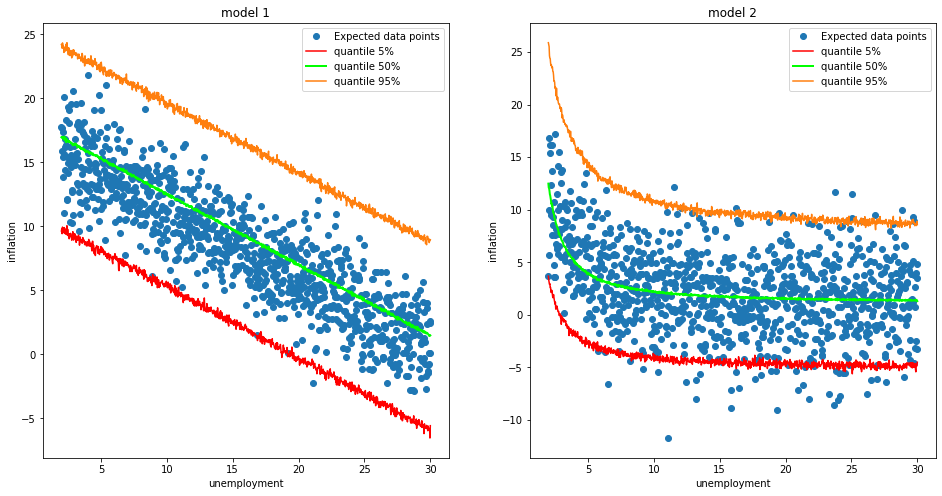

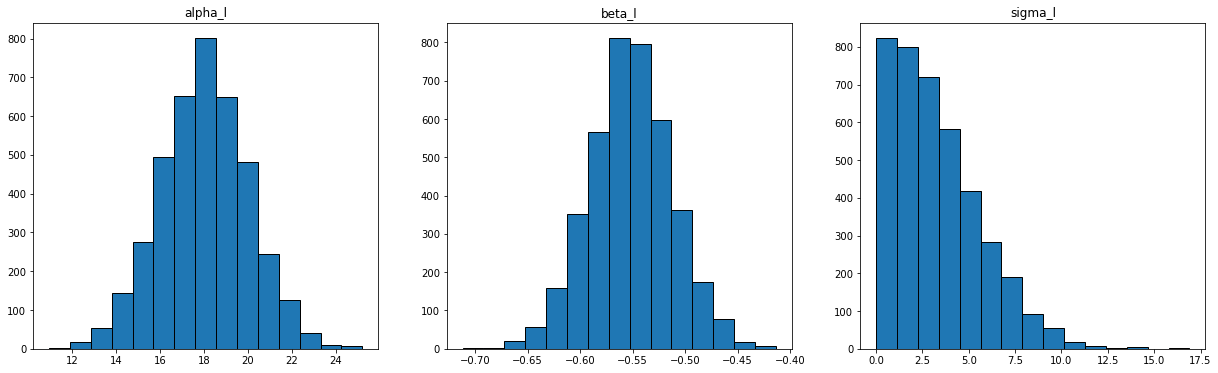

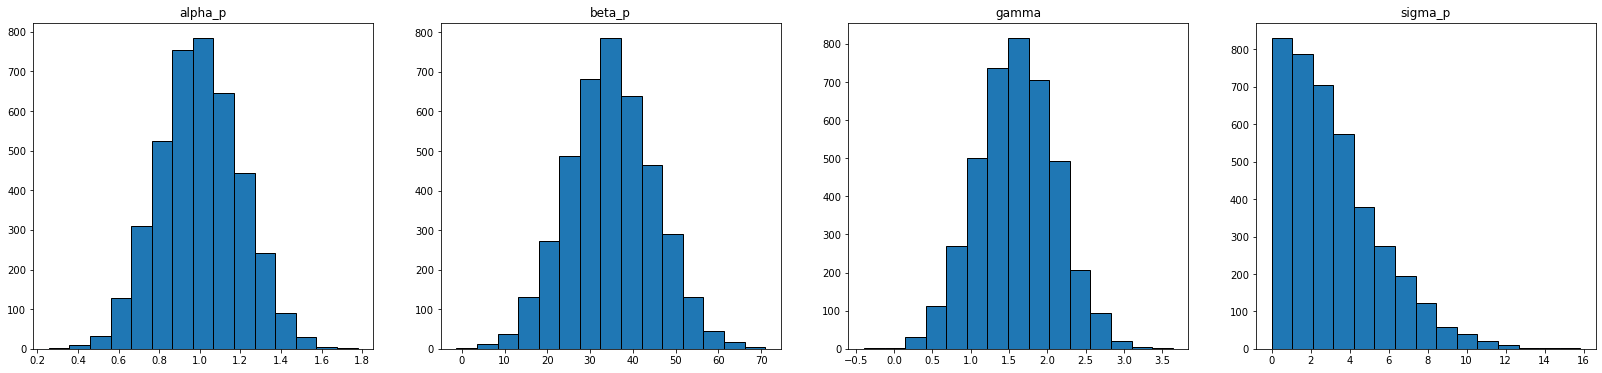

In [28]:
plot_prior(df_prior)

# Posterior analysis model 1 and model 2, model comparison -
# Data from all countries bundled together

### 4. and 5. - posterior analysis model 1 and model 2
a) There were no issues with the sampling

b) In the charts below

c) In the charts below

d) In the charts below

### 6. Model comparison
a) In the charts below

b) In the charts below

c) In the charts below

d) In the charts below

In [29]:
all_countries = concatenate_all_data(country_list=country_list)
span_start_idx = 0
span = len(all_countries[1])

In [30]:
fit1_all, fit2_all = sample_models_all_data(country=all_countries, span=span, span_start_idx=span_start_idx, model1=model_linear, model2=model_phillips)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)



chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)
chain 1 |██▉       | 00:01 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:02 Iteration:  400 / 1500 [ 26%]  (Warmup)






chain 1 |████▋     | 00:05 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:08 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:12 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:15 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:18 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:22 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:27 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:32 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▌         | 00:00 Status

chain 1 |█▏        | 00:03 Iteration:    1 / 1500 [  0%]  (Warmup)
chain 1 |█▊        | 00:04 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |██▎       | 00:07 Iteration:  200 / 1500 [ 13%]  (Warmup)
chain 1 |██▉       | 00:08 Iteration:  300 / 1500 [ 20%]  (Warmup)
chain 1 |███▌      | 00:09 Iteration:  400 / 1500 [ 26%]  (Warmup)
chain 1 |████▋     | 00:13 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:19 Iteration:  600 / 1500 [ 40%]  (Sampling)
chain 1 |█████▉    | 00:24 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:30 Iteration:  800 / 1500 [ 53%]  (Sampling)
chain 1 |███████   | 00:35 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:43 Iteration: 1000 / 1500 [ 66%]  (Sampling)
chain 1 |████████▏ | 00:49 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:55 Iteration: 1200 / 1500 [ 80%]  (Sam


INFO:cmdstanpy:CmdStan done processing.


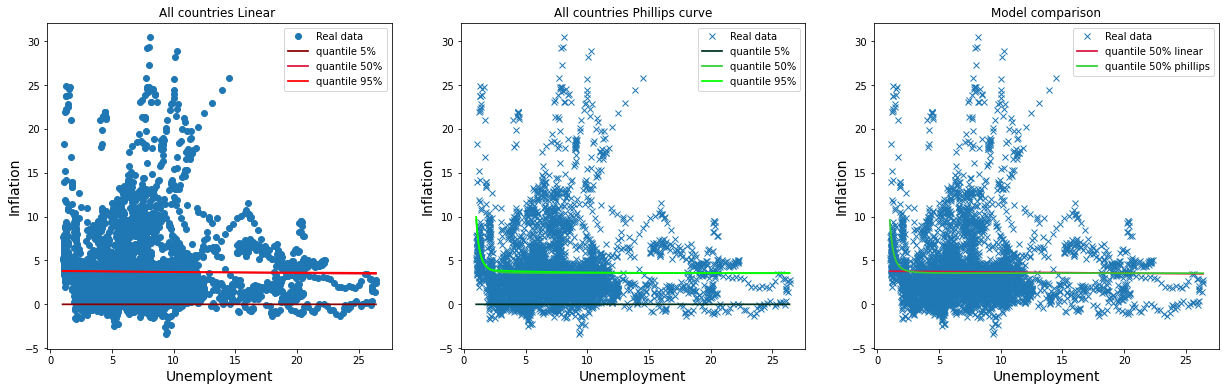

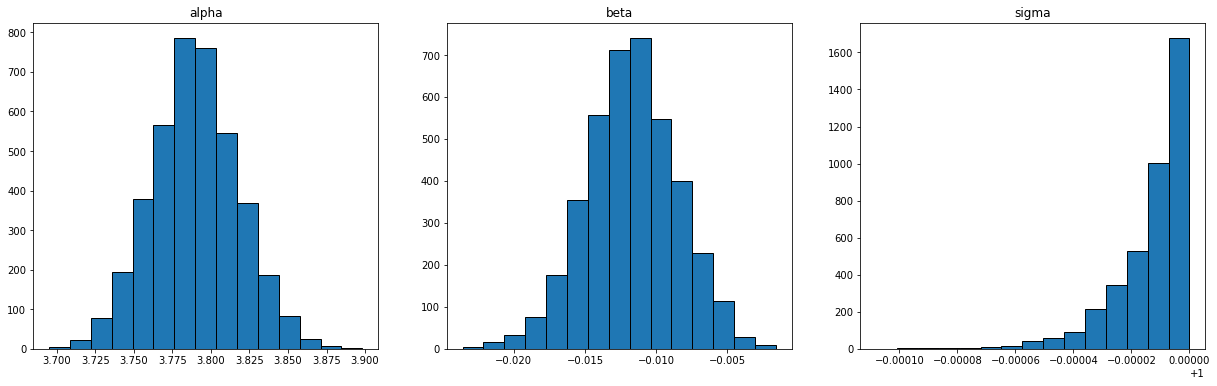

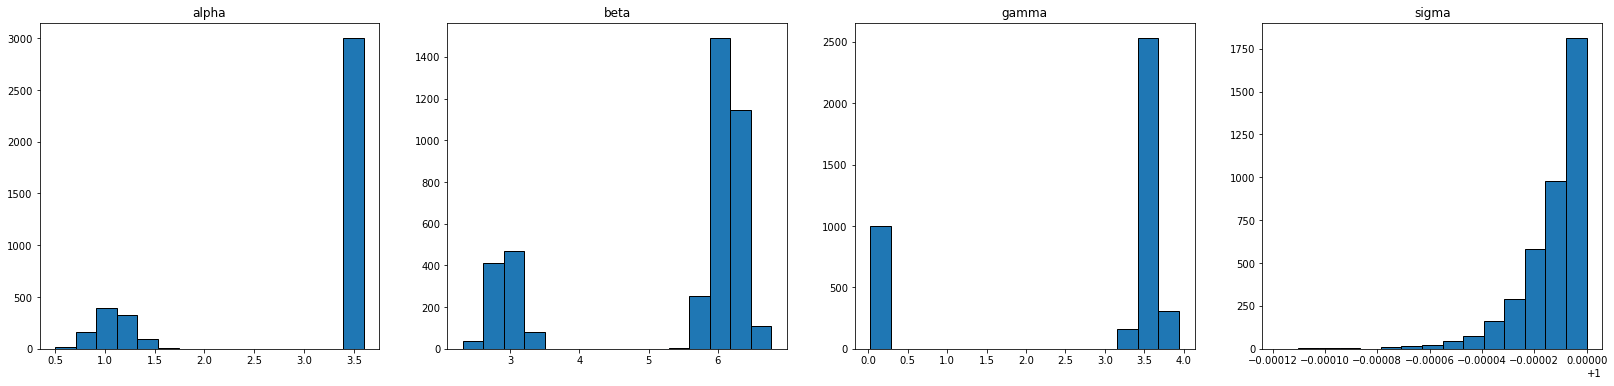

In [31]:
span = len(all_countries[1])
plot_results_all_data(country = all_countries, fit1 = fit1_all, fit2 = fit2_all, fig_nr = 0, span=span)

In [32]:
fit1_all.draws_pd()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,y_hat[5071],y_hat[5072],y_hat[5073],y_hat[5074],y_hat[5075],y_hat[5076],y_hat[5077],y_hat[5078],y_hat[5079],y_hat[5080]
0,-41385.3,0.998355,0.262638,4.0,15.0,0.0,41386.0,3.75352,-0.008657,0.999988,...,2.55459,1.80440,3.45461,2.10227,3.54412,4.11284,3.57481,3.67812,2.91868,3.33812
1,-41385.1,0.984357,0.262638,4.0,15.0,0.0,41385.5,3.76191,-0.008021,0.999991,...,3.66826,3.85293,4.03544,4.73836,2.52218,4.68465,3.87307,3.84466,3.55168,2.83758
2,-41385.2,0.929164,0.262638,3.0,15.0,0.0,41387.3,3.78036,-0.012735,0.999988,...,2.55744,3.34835,4.71542,3.97926,3.84623,2.71342,2.35086,2.84009,3.24938,2.75886
3,-41385.3,0.967232,0.262638,3.0,15.0,0.0,41386.4,3.76044,-0.009375,0.999995,...,3.64420,2.87328,4.55134,2.42497,1.49387,2.05723,2.47021,3.50219,3.04457,4.37641
4,-41385.2,0.985531,0.262638,3.0,7.0,0.0,41385.4,3.75911,-0.008854,0.999994,...,4.44949,1.92077,4.90707,1.81633,2.04354,1.39575,3.05568,5.04762,4.76264,4.02612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-41385.6,0.942918,0.239593,4.0,31.0,0.0,41386.9,3.76750,-0.008126,0.999996,...,4.34905,2.47582,4.51685,4.08503,4.27300,3.64296,4.25287,5.43163,2.63583,5.29094
3996,-41385.4,0.999143,0.239593,4.0,15.0,0.0,41386.3,3.75125,-0.008401,0.999987,...,4.91510,4.11403,3.18861,3.26968,3.80940,2.81933,3.11910,4.73366,4.59664,3.49809
3997,-41386.6,0.942266,0.239593,3.0,7.0,0.0,41387.0,3.74379,-0.005916,0.999969,...,2.16508,2.25447,5.19637,4.50936,3.45071,6.55934,4.31991,3.27176,4.42689,4.48472
3998,-41385.9,0.997348,0.239593,3.0,7.0,0.0,41386.8,3.74306,-0.008037,0.999985,...,3.62169,5.17042,4.55911,2.26485,4.37776,4.66025,2.43140,4.30095,2.77044,2.96156


In [33]:
fit1_all.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-41000.000,3.900000e-02,1.200000,-41000.000,-41000.000,-41000.0000,1000.0,6.4,1.0
alpha,3.800,7.200000e-04,0.028000,3.700,3.800,3.8000,1500.0,9.6,1.0
beta,-0.012,7.700000e-05,0.003200,-0.017,-0.012,-0.0065,1700.0,11.0,1.0
sigma,1.000,3.000000e-07,0.000013,1.000,1.000,1.0000,1900.0,12.0,1.0
mu[1],3.800,6.400000e-04,0.025000,3.700,3.800,3.8000,1536.0,9.6,1.0
...,...,...,...,...,...,...,...,...,...
y_hat[5076],3.500,1.600000e-02,0.990000,1.900,3.500,5.1000,3834.0,24.0,1.0
y_hat[5077],3.500,1.500000e-02,0.990000,1.900,3.500,5.1000,4066.0,26.0,1.0
y_hat[5078],3.500,1.500000e-02,0.980000,1.900,3.500,5.1000,4138.0,26.0,1.0


In [34]:
arviz_fit1_all = az.from_cmdstanpy(fit1_all, log_likelihood='log_lik', posterior_predictive='y_hat')

arviz_fit2_all = az.from_cmdstanpy(fit2_all, log_likelihood='log_lik', posterior_predictive='y_hat')

arviz_dict_all = dict(arviz_fit1_all = arviz_fit1_all, arviz_fit2_all = arviz_fit2_all)

In [35]:
loo_all = az.compare(arviz_dict_all, 'loo')
loo_all

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
arviz_fit1_all,0,-45940.416933,27.620252,0.000000,0.454885,1840.733694,0.000000,False,log
arviz_fit2_all,1,-45992.816804,1037.366849,52.399871,0.545115,1856.135175,54.467807,False,log


<AxesSubplot:xlabel='Log'>

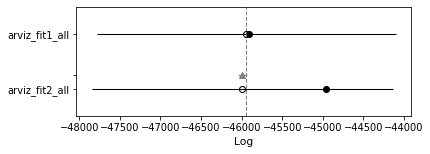

In [36]:
az.plot_compare(loo_all)

In [37]:
waic_all = az.compare(arviz_dict_all, 'waic')
waic_all

c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
arviz_fit1_all,0,-45940.408781,27.612100,0.00000,0.582719,1840.733014,0.000000,False,log
arviz_fit2_all,1,-48774.657921,3819.207966,2834.24914,0.417281,2181.055049,747.430412,True,log


<AxesSubplot:xlabel='Log'>

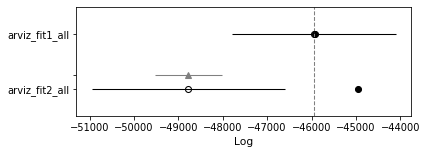

In [38]:
az.plot_compare(waic_all)

# Posterior analysis model 1 and model 2, model comparison -
# Data from particular countries

### 4. and 5. - posterior analysis model 1 and model 2
a) There were no issues with the sampling

b) In the charts below

c) In the charts below

d) In the charts below

### 6. Model comparison
a) In the charts below

b) In the charts below

c) In the charts below

d) In the charts below

In [39]:
span_start_idx = 0
country_and_fits = []
for country in country_list:
    span = len(country[0])
    fit1, fit2 = sample_models(country=country, span=span, span_start_idx=span_start_idx, model1=model_linear, model2=model_phillips)
    data = country, fit1, fit2
    country_and_fits.append(data)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▉    | 00:01 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |███████   | 00:01 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1000 / 1500 [ 66%]  (Sampling)

chain 1 |████████▏ | 00:01 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:02 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:02 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)





chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:01 Iteration:  300 / 1500 [ 20%]  (Warmup)
chain 1 |███▌      | 00:01 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:02 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:02 Iteration:  600 / 1500 [ 40%]  (Sampling)




chain 1 |█████▉    | 00:02 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:03 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:03 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:04 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:04 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:05 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)
chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |██████▍   | 00:01 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████▋  | 00:01 Iteration: 1000 / 1500 [ 66%]  (Sampling)



chain 1 |████████▊ | 00:02 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:02 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 1400 / 1500 [ 93%]  (Sampling)
chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)

chain 1 |██▉       | 00:01 Iteration:  300 / 1500 [ 20%]  (Warmup)
chain 1 |███▌      | 00:02 Iteration:  400 / 1500 [ 26%]  (Warmup)



chain 1 |████▋     | 00:02 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:03 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:03 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:04 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:04 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:06 Iteration: 1000 / 1500 [ 66%]  (Sampling)
chain 1 |████████▏ | 00:07 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:08 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |████


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)




chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)



chain 1 |██████▍   | 00:01 Iteration:  800 / 1500 [ 53%]  (Sampling)



chain 1 |███████▋  | 00:01 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:01 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:02 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:02 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:02 Iteration: 1400 / 1500 [ 93%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:01 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:01 Iteration:  400 / 1500 [ 26%]  (Warmup)



chain 1 |████▋     | 00:02 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:02 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:02 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:03 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:03 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:04 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:06 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:06 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)





chain 1 |█████▎    | 00:00 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |██████▍   | 00:01 Iteration:  800 / 1500 [ 53%]  (Sampling)




chain 1 |███████▋  | 00:01 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:02 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:02 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:02 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:02 Sampling completed                       
chain 2 |██████████| 00:02 Sampling completed                       
chain 3 |██████████| 00:02 Sampling completed                       
chain 4 |██████████| 00:02 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)
chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)



chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:01 Iteration:  300 / 1500 [ 20%]  (Warmup)
chain 1 |███▌      | 00:01 Iteration:  400 / 1500 [ 26%]  (Warmup)
chain 1 |████▋     | 00:02 Iteration:  501 / 1500 [ 33%]  (Sampling)
chain 1 |█████▎    | 00:02 Iteration:  600 / 1500 [ 40%]  (Sampling)
chain 1 |█████▉    | 00:02 Iteration:  700 / 1500 [ 46%]  (Sampling)




chain 1 |██████▍   | 00:03 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:03 Iteration:  900 / 1500 [ 60%]  (Sampling)
chain 1 |███████▋  | 00:04 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:05 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:06 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 1 |█████████▍| 0


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)



chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)
chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▉    | 00:01 Iteration:  700 / 1500 [ 46%]  (Sampling)

chain 1 |██████▍   | 00:01 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:01 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:02 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:03 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:04 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:04 Iteration: 1400 / 1500 [ 93%]  (Sampling)

chain 1 |██████████| 00:04 Sampling completed                       
chain 2 |██████████| 00:04 Sampling completed                       
chain 3 |█


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▏        | 00:01 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:02 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:03 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:03 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:04 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:05 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:05 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:06 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:07 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:08 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:10 Iteration: 1100 / 1500 [ 73%]  (Sampling)




chain 1 |████████▊ | 00:11 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)
chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▉    | 00:01 Iteration:  700 / 1500 [ 46%]  (Sampling)
chain 1 |██████▍   | 00:01 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:02 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:02 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:02 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:03 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 1 |█████████▍| 00:03 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:04 Iteration: 1400 / 1500 [ 93%]  (Sampling)


chain 1 |██████████| 00:05 Sampling completed                       
chain 2 |█████


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:02 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:02 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:04 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:04 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:05 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:05 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:06 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:07 Iteration:  700 / 1500 [ 46%]  (Sampling)
chain 1 |██████▍   | 00:07 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:09 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:10 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:11 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:12 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |████


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |██▎       | 00:00 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |███▌      | 00:00 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:01 Iteration:  501 / 1500 [ 33%]  (Sampling)





chain 1 |█████▉    | 00:02 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:02 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:03 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:03 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:04 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:04 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:06 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 1400 / 1500 [ 93%]  (Sampling)
chain 1 |██████████| 00:07 Sampling completed                       
chain 2 |


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |█▏        | 00:02 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:03 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:04 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:04 Iteration:  300 / 1500 [ 20%]  (Warmup)

chain 1 |███▌      | 00:05 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:06 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:07 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:10 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:11 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:13 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:14 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:15 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:17 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:00 Iteration:  100 / 1500 [  6%]  (Warmup)

chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)





chain 1 |████▋     | 00:01 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:01 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:02 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:04 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:04 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:05 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:05 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:06 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:07 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:08 Iteration: 1400 / 1500 [ 93%]  (Sampling)


chain 1 |██████████| 00:09 Sampling completed                       
chain


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)
chain 1 |███▌      | 00:02 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |█████▎    | 00:03 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:06 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:06 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:07 Iteration:  900 / 1500 [ 60%]  (Sampling)

chain 1 |███████▋  | 00:08 Iteration: 1000 / 1500 [ 66%]  (Sampling)
chain 1 |████████▏ | 00:08 Iteration: 1100 / 1500 [ 73%]  (Sampling)

chain 1 |████████▊ | 00:09 Iteration: 1200 / 1500 [ 80%]  (Sampling)
chain 1 |█████████▍| 00:10 Iteration: 1300 / 1500 [ 86%]  (Sampling)

chain 1 |██████████| 00:10 Iteration: 1400 / 1500 [ 93%]  (Sampling)























chain 1 |██████████| 00:19 Sampling completed                       
chain 2 |██████████| 00:19 Sampling completed                     


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status








chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▉    | 00:01 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:01 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:02 Iteration:  900 / 1500 [ 60%]  (Sampling)




chain 1 |███████▋  | 00:03 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:04 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:04 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:04 Iteration: 1300 / 1500 [ 86%]  (Sampling)
chain 1 |██████████| 00:05 Sampling completed                       
chain 2 |██████████| 00:05 Sampling completed                       
chain 3 |██████████| 00:05 Sampling completed                       
chain 4 |██████████| 00:05 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |█▏        | 00:01 Iteration:    1 / 1500 [  0%]  (Warmup)

chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:02 Iteration:  200 / 1500 [ 13%]  (Warmup)
chain 1 |██▉       | 00:02 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:03 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:05 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:06 Iteration:  600 / 1500 [ 40%]  (Sampling)


chain 1 |█████▉    | 00:07 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:07 Iteration:  800 / 1500 [ 53%]  (Sampling)

chain 1 |███████   | 00:08 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:09 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:11 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:12 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |█▏        | 00:00 Iteration:    1 / 1500 [  0%]  (Warmup)




chain 1 |██▉       | 00:00 Iteration:  300 / 1500 [ 20%]  (Warmup)
chain 1 |████▋     | 00:00 Iteration:  501 / 1500 [ 33%]  (Sampling)



chain 1 |█████▉    | 00:02 Iteration:  700 / 1500 [ 46%]  (Sampling)


chain 1 |██████▍   | 00:03 Iteration:  800 / 1500 [ 53%]  (Sampling)


chain 1 |███████   | 00:04 Iteration:  900 / 1500 [ 60%]  (Sampling)


chain 1 |███████▋  | 00:04 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:05 Iteration: 1100 / 1500 [ 73%]  (Sampling)


chain 1 |████████▊ | 00:06 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 |█████████▍| 00:06 Iteration: 1300 / 1500 [ 86%]  (Sampling)


chain 1 |██████████| 00:07 Iteration: 1400 / 1500 [ 93%]  (Sampling)

chain 1 |██████████| 00:07 Sampling completed                       
chain 2 |██████████| 00:07 Sampling completed                       
chain 3 |


INFO:cmdstanpy:CmdStan done processing.


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status




chain 1 |█▏        | 00:01 Iteration:    1 / 1500 [  0%]  (Warmup)


chain 1 |█▊        | 00:01 Iteration:  100 / 1500 [  6%]  (Warmup)


chain 1 |██▎       | 00:01 Iteration:  200 / 1500 [ 13%]  (Warmup)


chain 1 |██▉       | 00:02 Iteration:  300 / 1500 [ 20%]  (Warmup)


chain 1 |███▌      | 00:02 Iteration:  400 / 1500 [ 26%]  (Warmup)


chain 1 |████▋     | 00:03 Iteration:  501 / 1500 [ 33%]  (Sampling)


chain 1 |█████▎    | 00:04 Iteration:  600 / 1500 [ 40%]  (Sampling)



chain 1 |█████▉    | 00:04 Iteration:  700 / 1500 [ 46%]  (Sampling)

chain 1 |██████▍   | 00:06 Iteration:  800 / 1500 [ 53%]  (Sampling)



chain 1 |███████   | 00:07 Iteration:  900 / 1500 [ 60%]  (Sampling)

chain 1 |███████▋  | 00:08 Iteration: 1000 / 1500 [ 66%]  (Sampling)


chain 1 |████████▏ | 00:09 Iteration: 1100 / 1500 [ 73%]  (Sampling)



chain 1 |████████▊ | 00:10 Iteration: 1200 / 1500 [ 80%]  (Sampling)


chain 1 


INFO:cmdstanpy:CmdStan done processing.


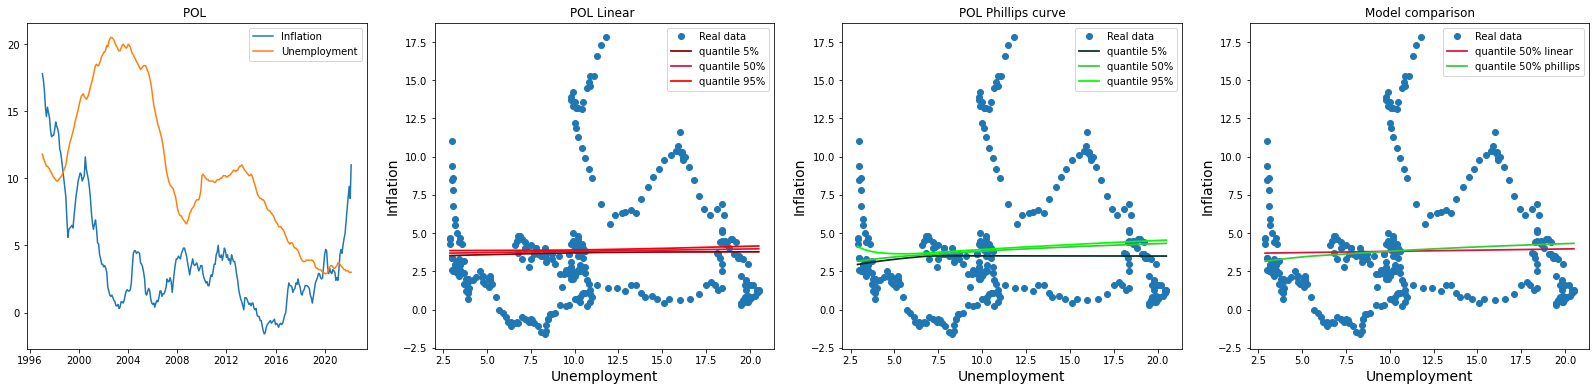

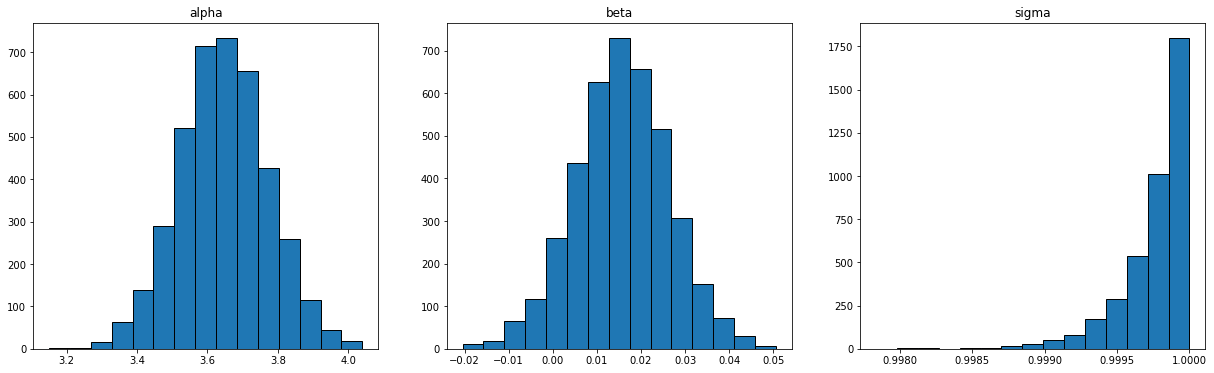

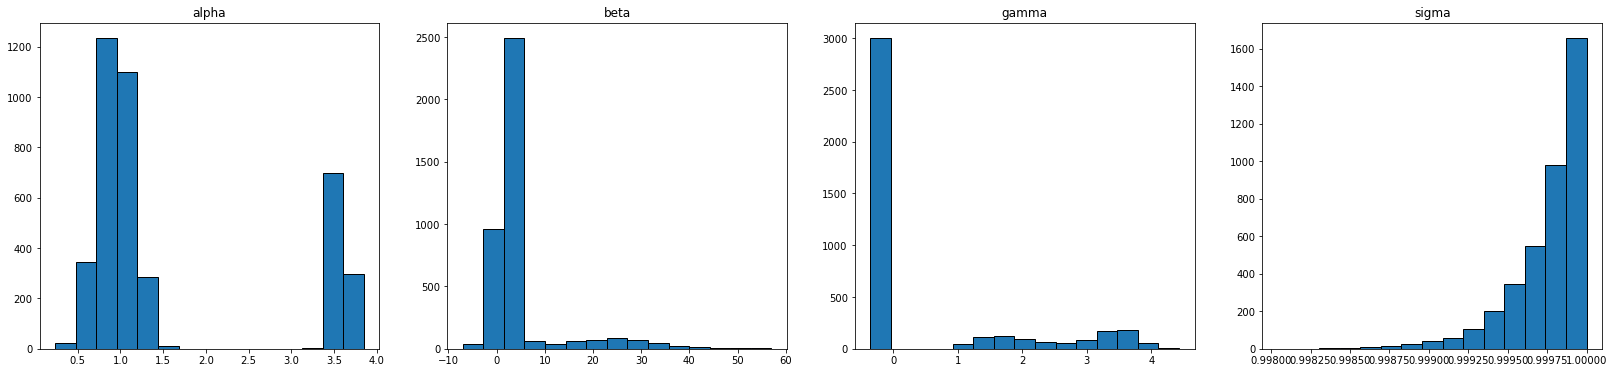

c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
arviz_fit1,0,-2541.007736,21.425630,0.000000,1.0,251.996264,0.000000,False,log
arviz_fit2,1,-2604.238259,154.450425,63.230522,0.0,259.037091,12.114861,False,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
arviz_fit1,0,-2540.985384,21.403277,0.000000,1.000000e+00,251.991732,0.000000,True,log
arviz_fit2,1,-2623.155022,173.367188,82.169639,1.072920e-11,261.527445,14.388949,True,log


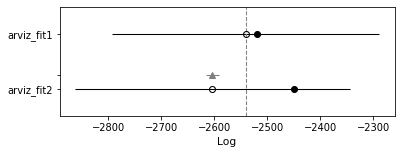

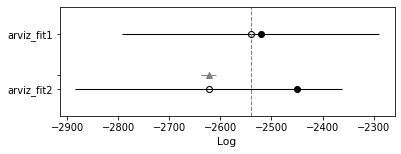

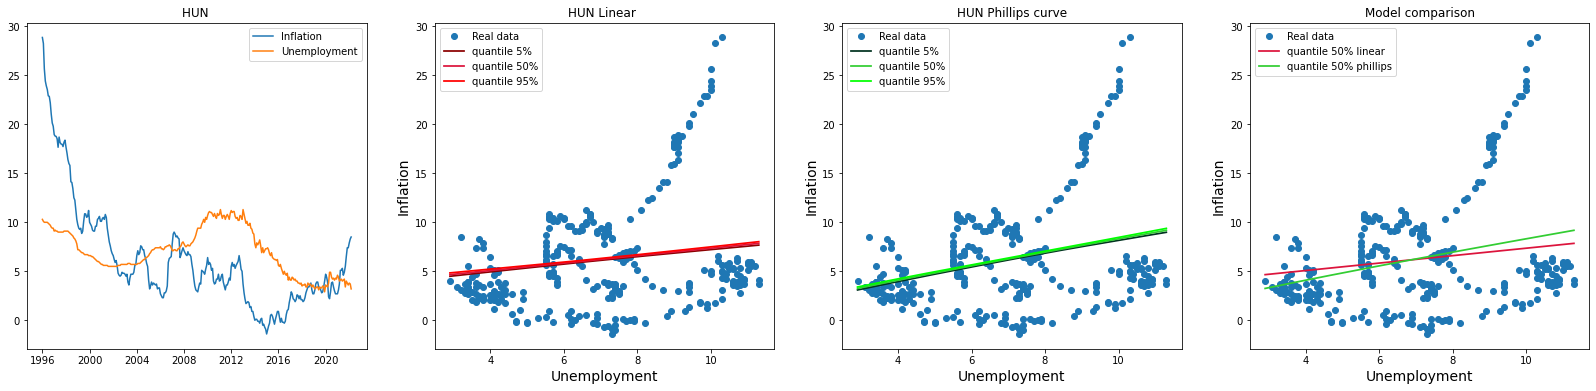

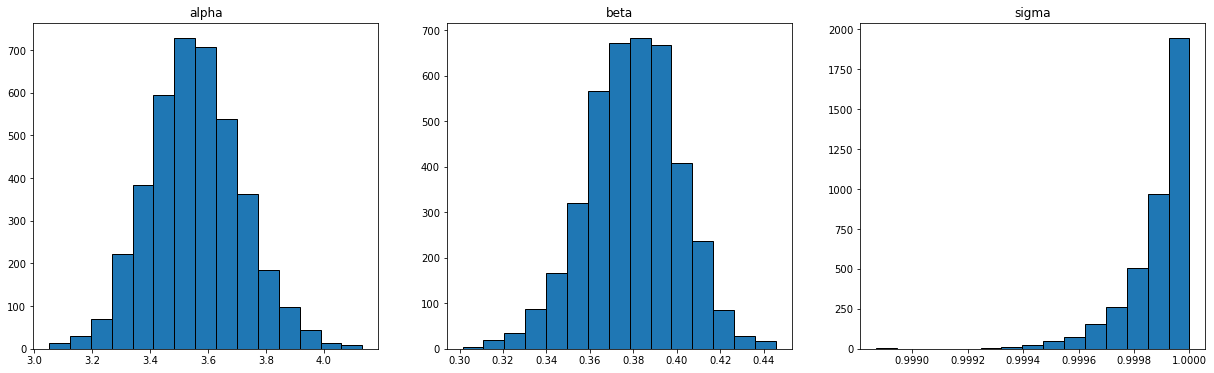

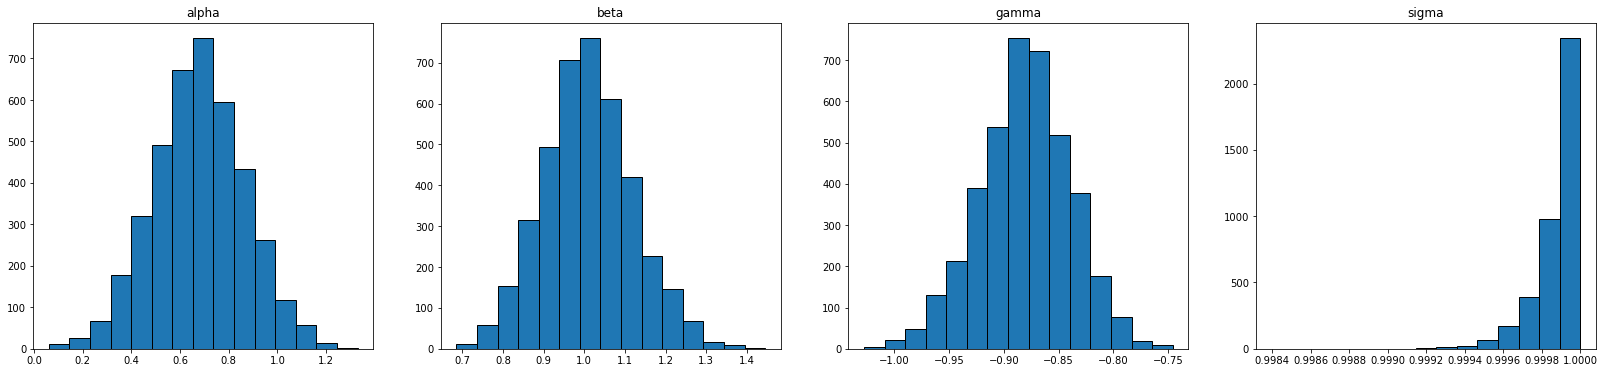

c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:703: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
arviz_fit2,0,-4588.586604,54.221347,0.000000,0.467772,470.161445,0.000000,False,log
arviz_fit1,1,-4697.542637,50.388785,108.956033,0.532228,526.269097,72.144605,True,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
arviz_fit2,0,-4588.975101,54.609845,0.000000,0.467761,470.281808,0.000000,True,log
arviz_fit1,1,-4697.547614,50.393761,108.572512,0.532239,526.270470,72.056695,True,log


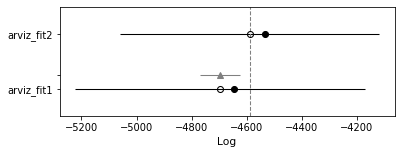

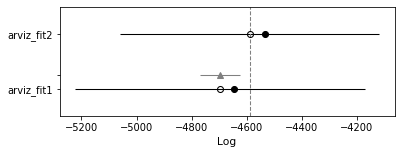

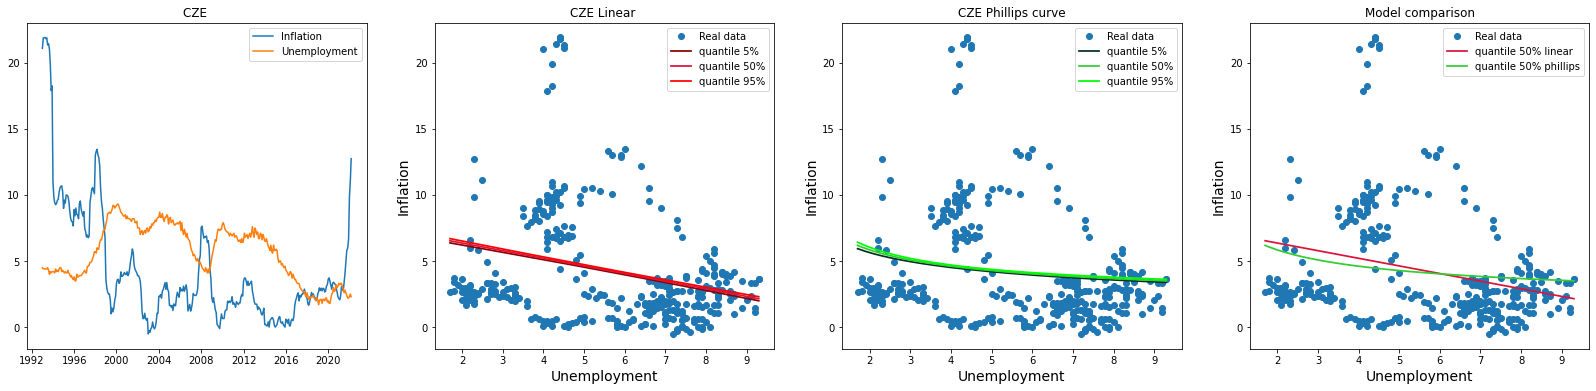

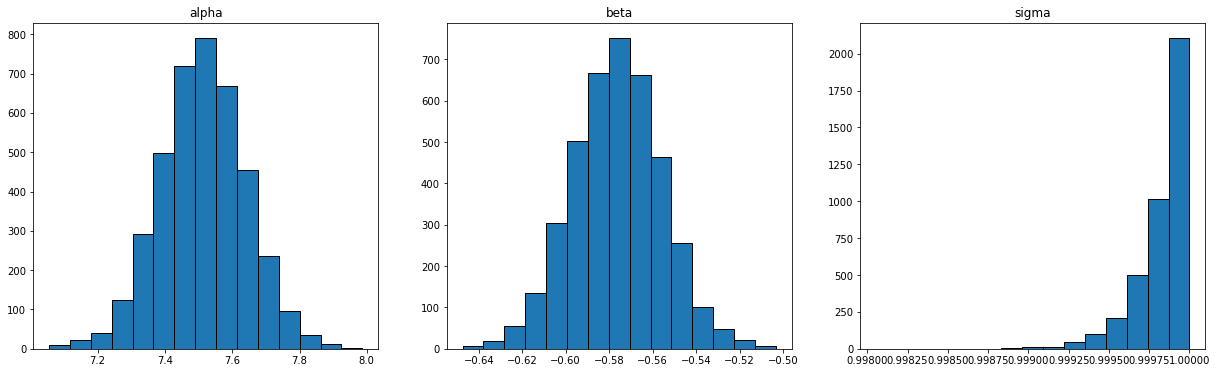

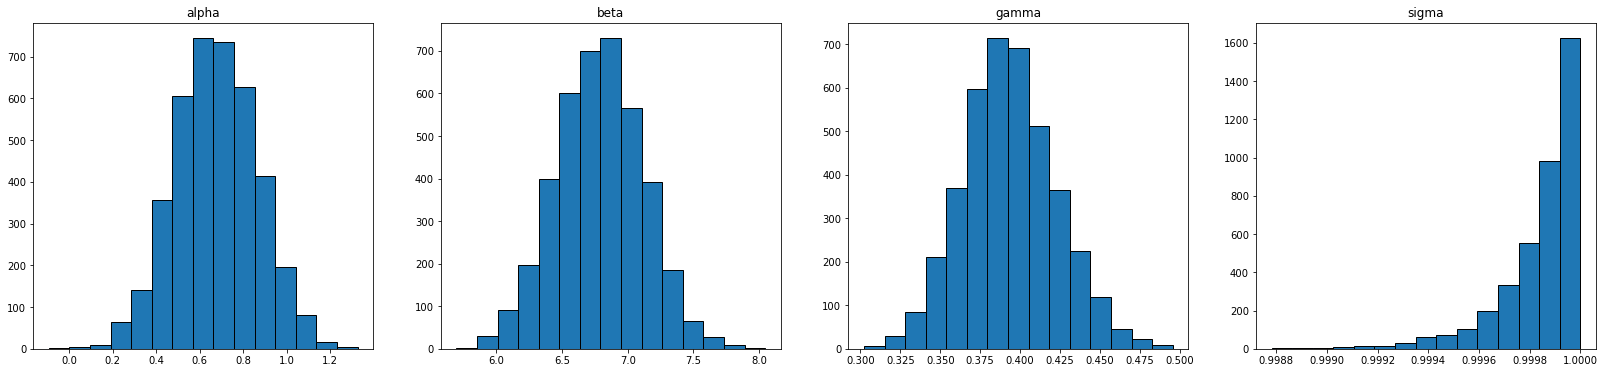

c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
arviz_fit1,0,-3562.520358,25.689812,0.000000,0.621845,436.760513,0.000000,False,log
arviz_fit2,1,-3713.981422,25.385095,151.461064,0.378155,464.946261,40.451828,False,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
arviz_fit1,0,-3562.610255,25.779709,0.00000,0.621812,436.78477,0.000000,True,log
arviz_fit2,1,-3713.818745,25.222418,151.20849,0.378188,464.90729,40.407015,True,log


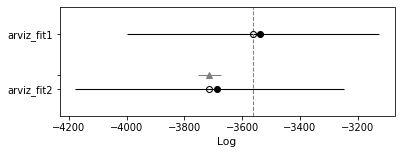

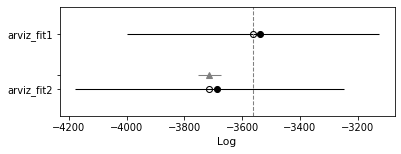

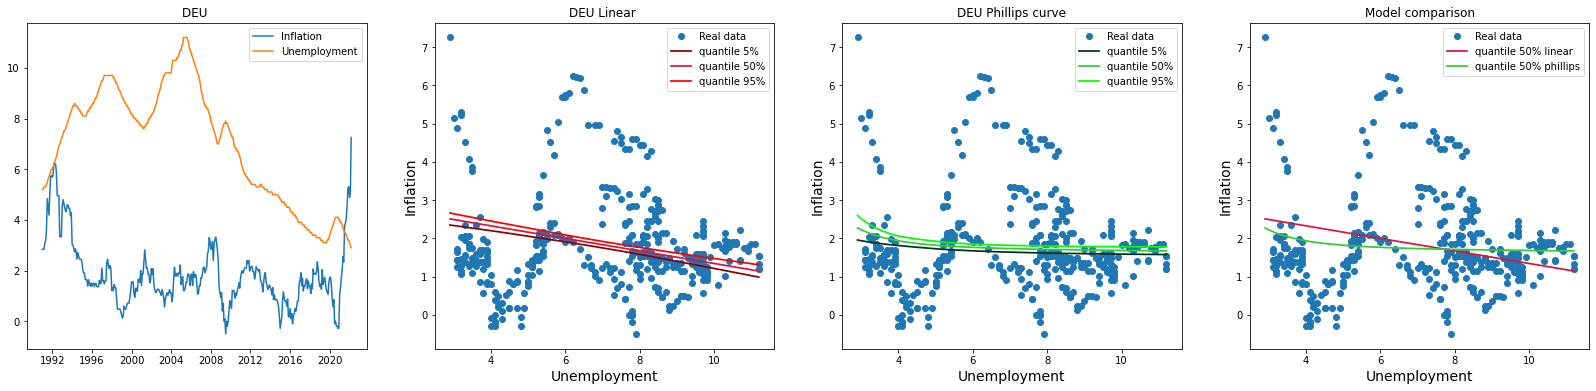

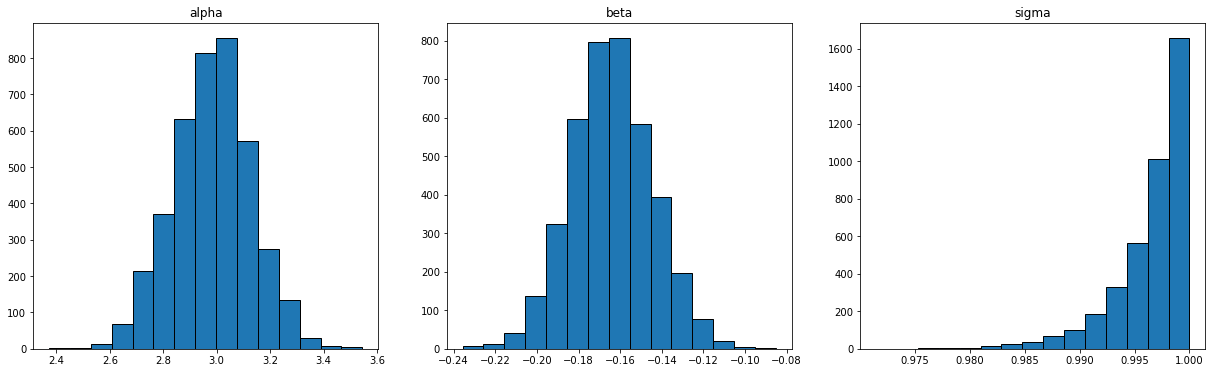

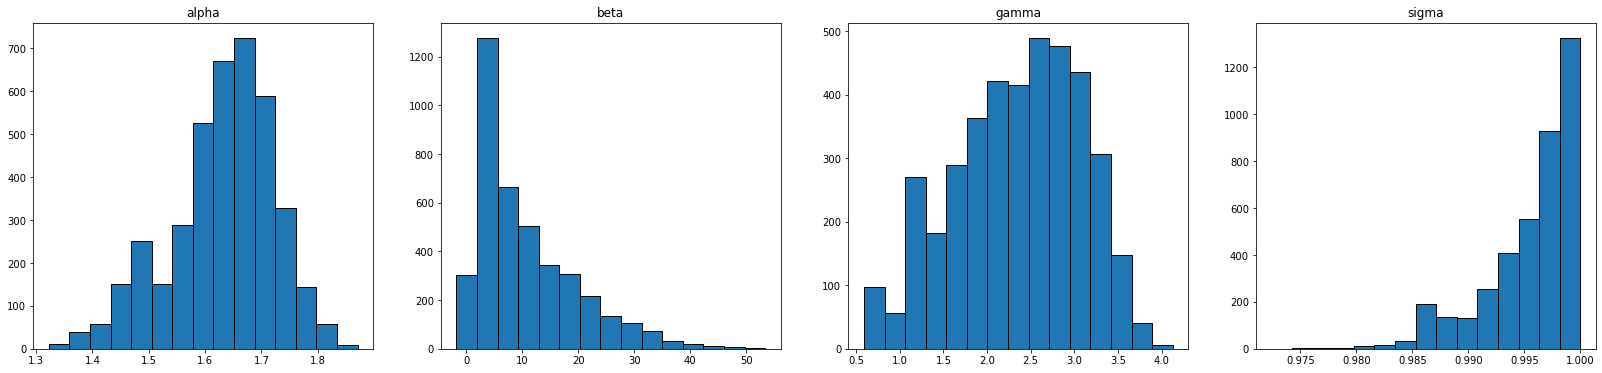

c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
arviz_fit2,0,-656.083836,4.117984,0.000000,0.870364,33.496122,0.000000,False,log
arviz_fit1,1,-671.054781,2.919418,14.970945,0.129636,30.722747,6.351991,False,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
arviz_fit2,0,-656.105505,4.139653,0.000000,0.869409,33.503275,0.000000,True,log
arviz_fit1,1,-671.053229,2.917866,14.947724,0.130591,30.722383,6.357451,False,log


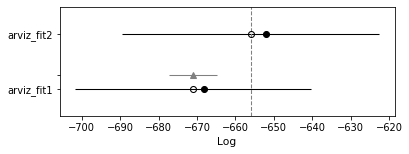

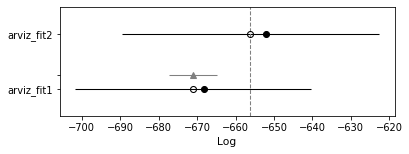

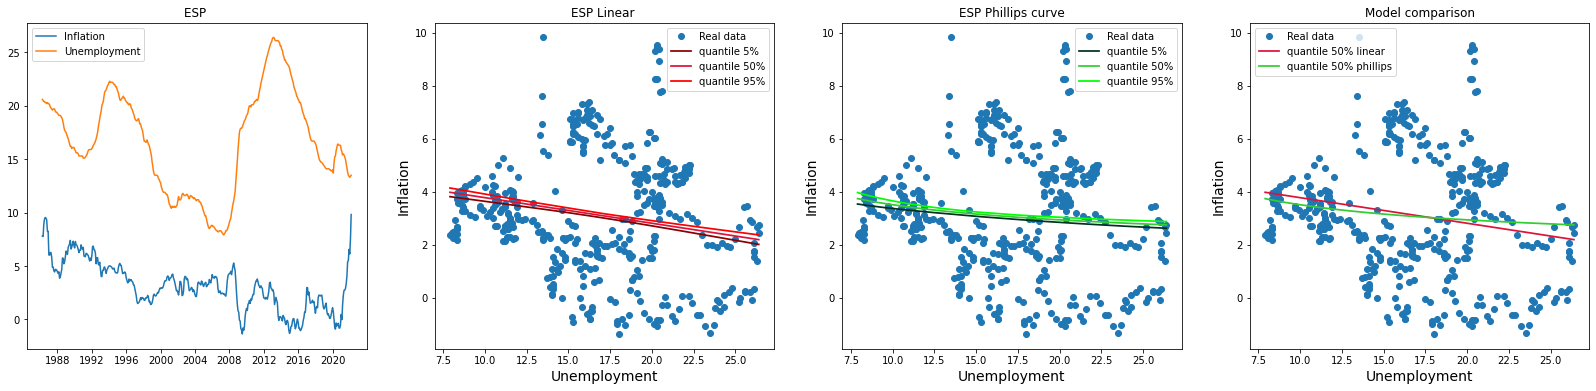

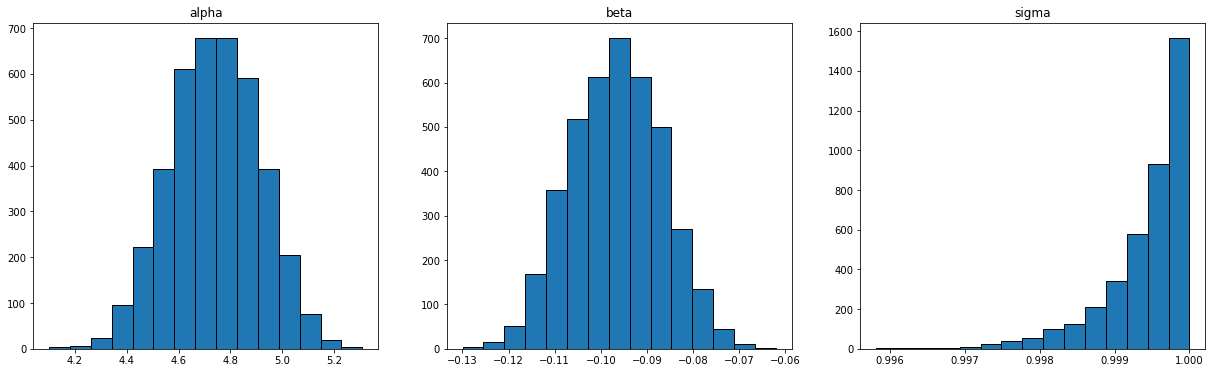

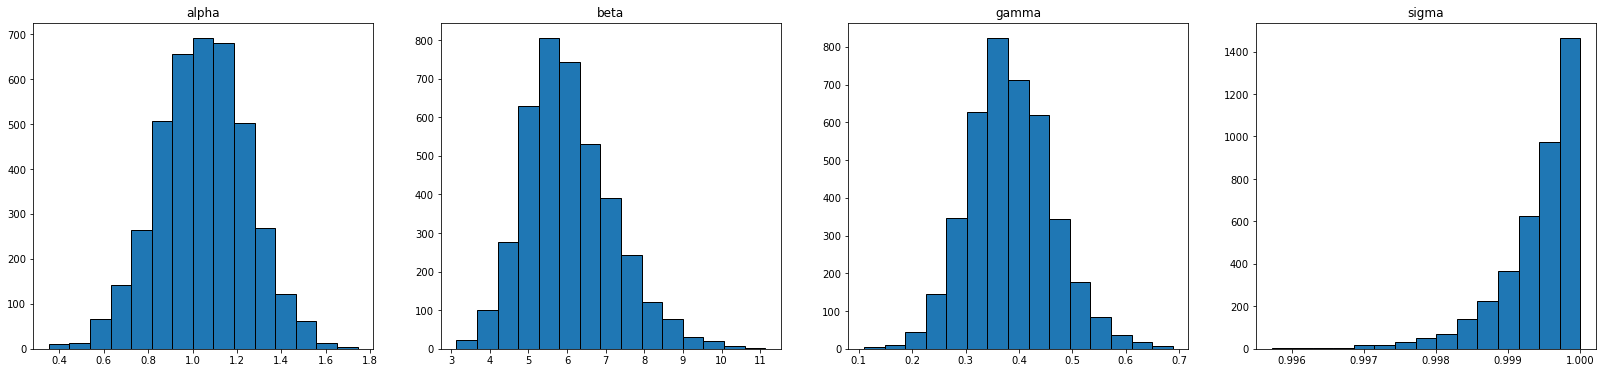

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
arviz_fit1,0,-1465.339551,7.845718,0.00000,0.494395,70.845105,0.000000,False,log
arviz_fit2,1,-1467.005181,7.072027,1.66563,0.505605,71.142390,8.210124,False,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
arviz_fit1,0,-1465.343637,7.849804,0.00000,0.494368,70.845634,0.000000,False,log
arviz_fit2,1,-1467.007098,7.073944,1.66346,0.505632,71.142653,8.210115,False,log


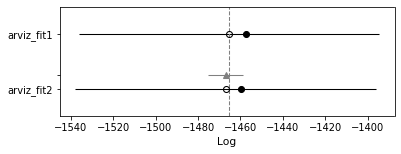

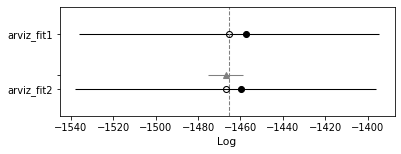

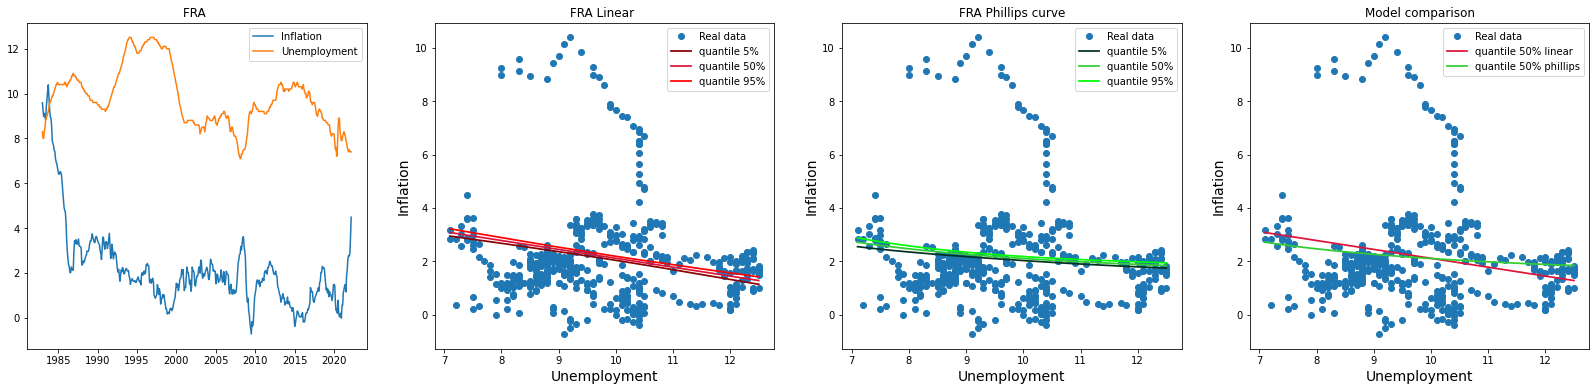

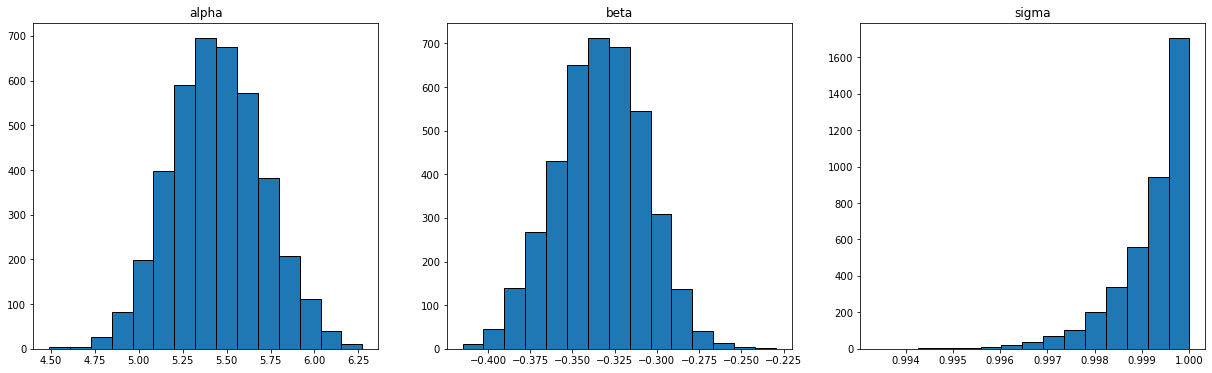

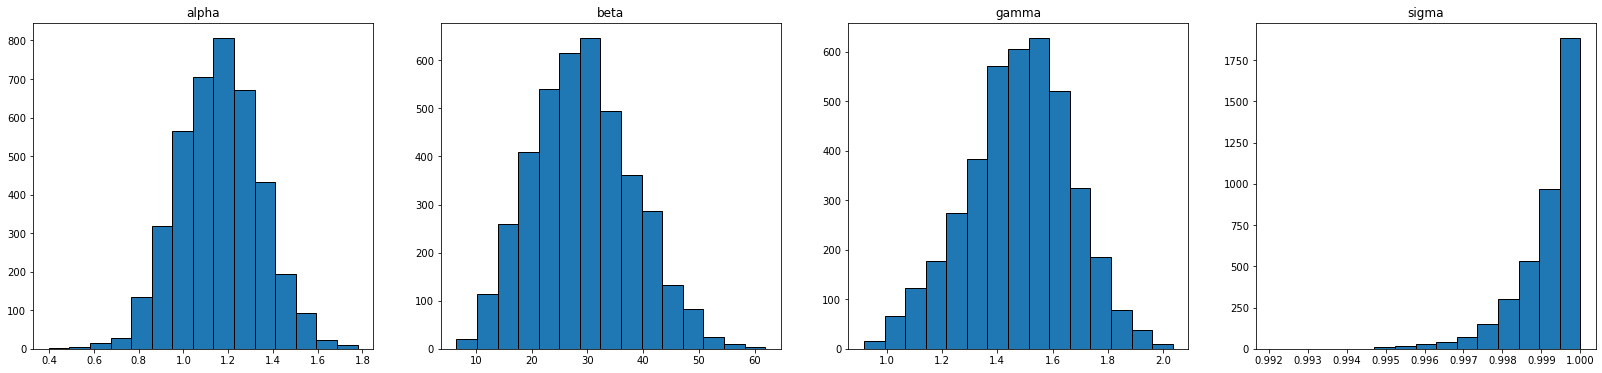

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
arviz_fit2,0,-1275.952719,4.789627,0.000000,0.768906,105.139385,0.00000,False,log
arviz_fit1,1,-1287.940935,4.758108,11.988216,0.231094,101.110307,7.46594,False,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
arviz_fit2,0,-1275.948800,4.785708,0.0000,0.768936,105.138669,0.000000,False,log
arviz_fit1,1,-1287.938999,4.756173,11.9902,0.231064,101.109922,7.465473,False,log


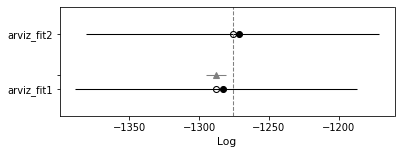

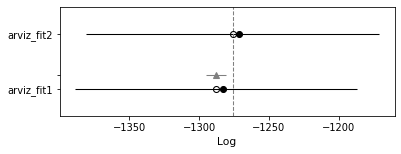

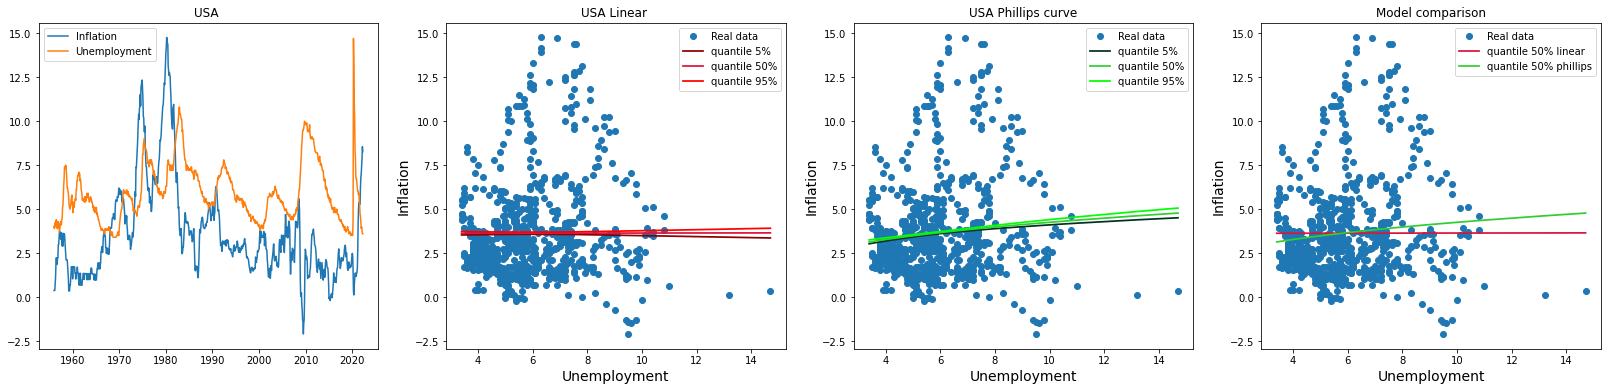

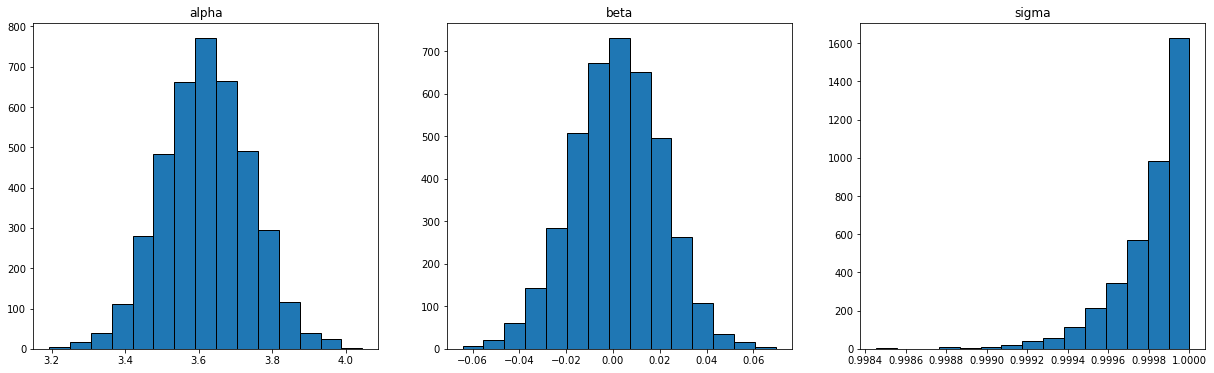

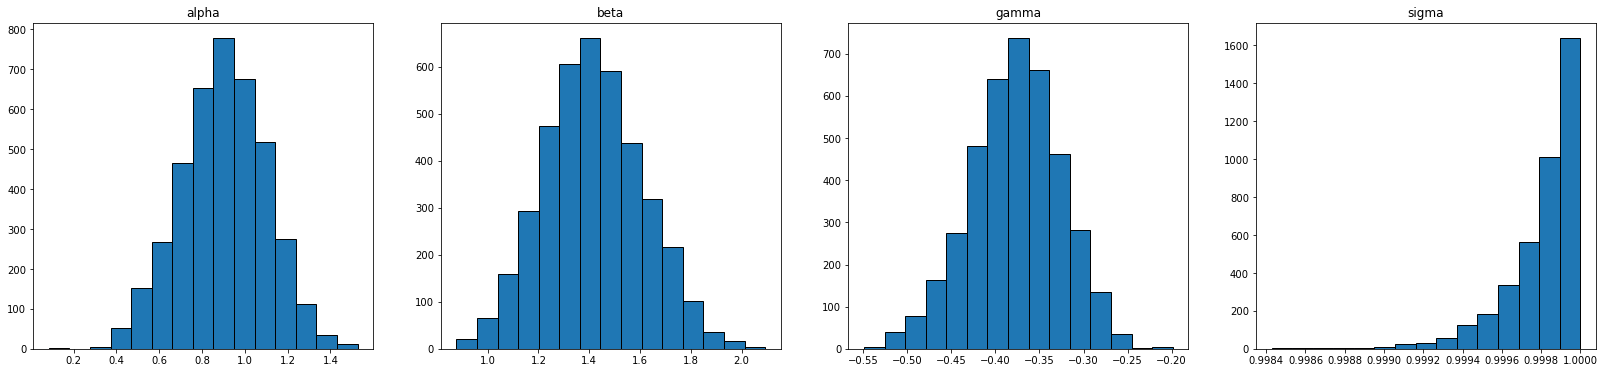

c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
arviz_fit2,0,-3780.228720,15.428225,0.000000,0.626046,232.480906,0.00000,False,log
arviz_fit1,1,-3816.851022,13.568725,36.622303,0.373954,239.313026,21.00886,False,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
arviz_fit2,0,-3780.234371,15.433876,0.000000,0.626039,232.481632,0.000000,True,log
arviz_fit1,1,-3816.850189,13.567892,36.615818,0.373961,239.313024,21.008526,False,log


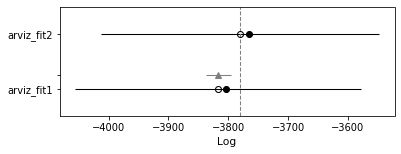

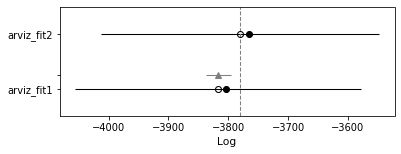

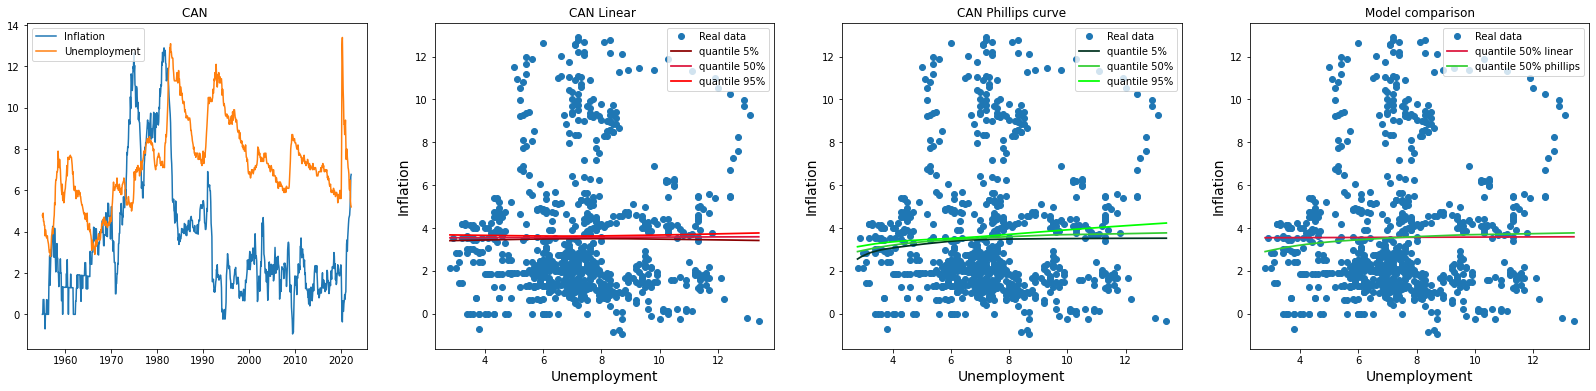

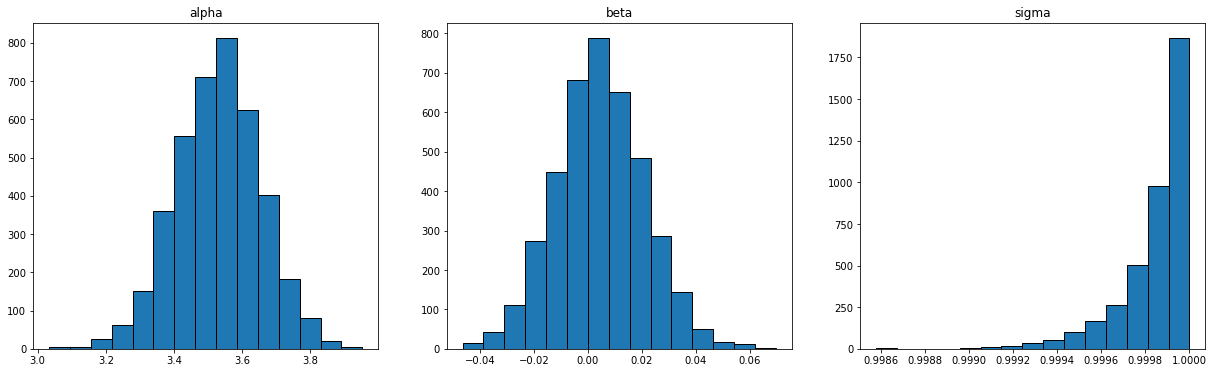

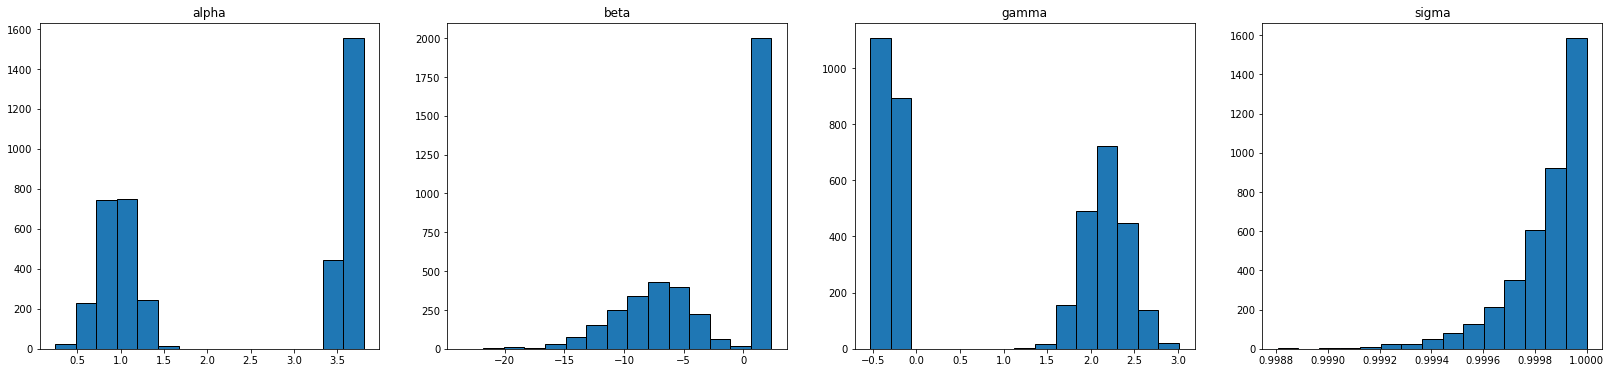

c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
arviz_fit1,0,-4349.627561,16.517388,0.000000,0.520083,224.150687,0.000000,False,log
arviz_fit2,1,-4352.169175,57.125895,2.541614,0.479917,226.089132,9.790929,False,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
arviz_fit1,0,-4349.602017,16.491844,0.000000,0.579364,224.148635,0.000000,False,log
arviz_fit2,1,-4357.206288,62.163008,7.604271,0.420636,226.451407,9.652361,True,log


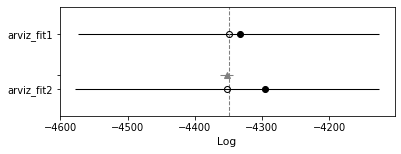

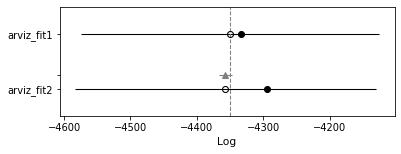

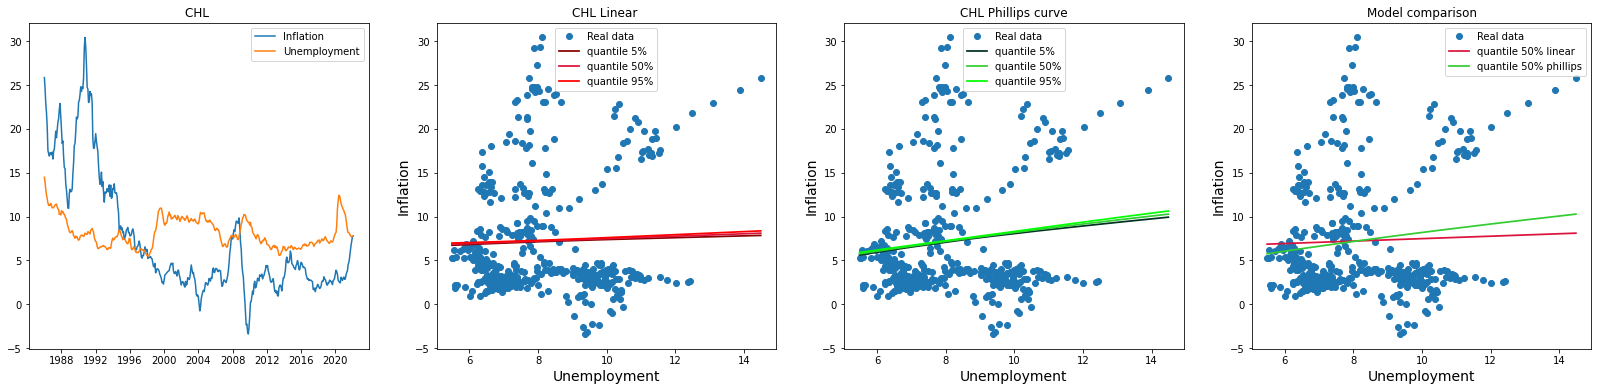

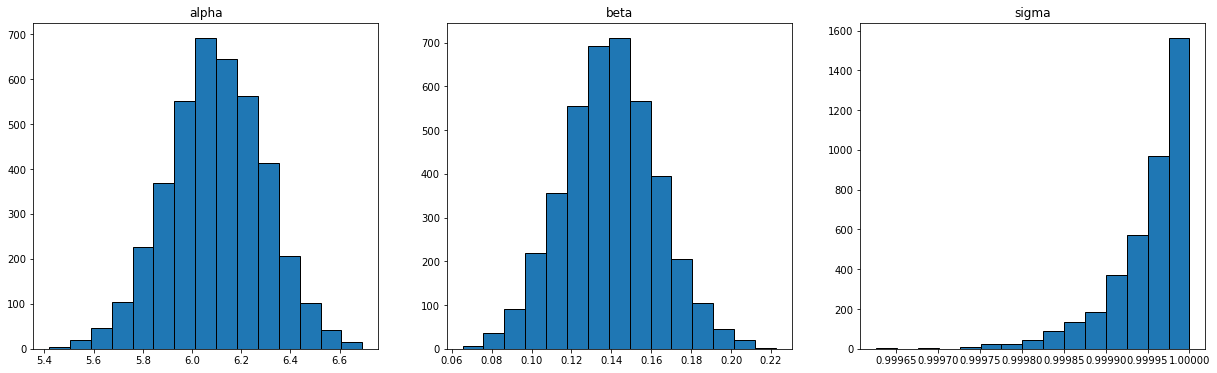

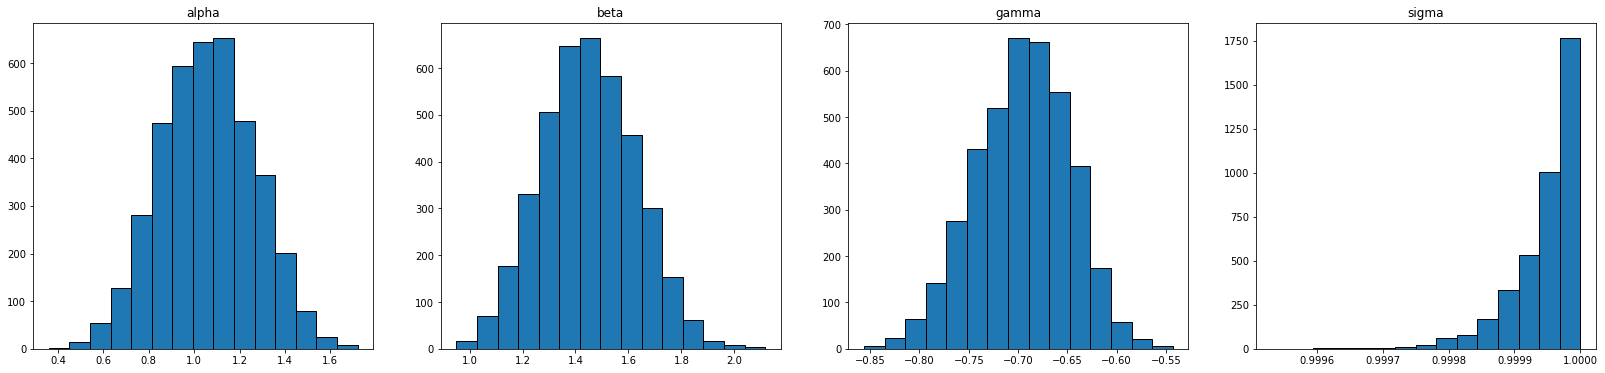

c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:703: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:703: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWa

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
arviz_fit2,0,-10287.707910,110.210073,0.000000,0.452487,792.870304,0.000000,True,log
arviz_fit1,1,-10352.942344,85.322564,65.234434,0.547513,810.401751,95.882023,True,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
arviz_fit2,0,-10289.875089,112.377253,0.000000,0.452523,793.110207,0.000000,True,log
arviz_fit1,1,-10353.709775,86.089996,63.834686,0.547477,810.516270,95.419677,True,log


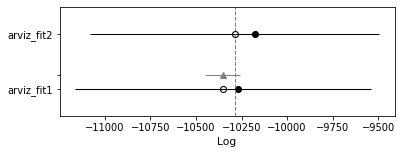

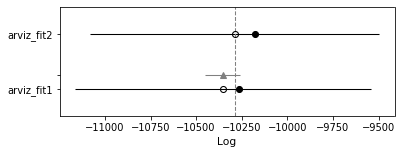

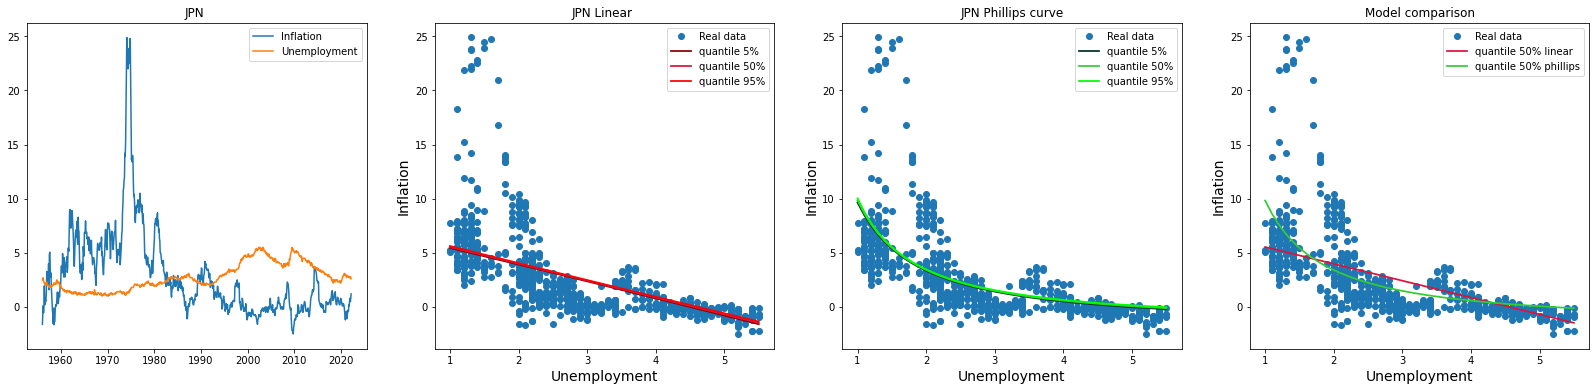

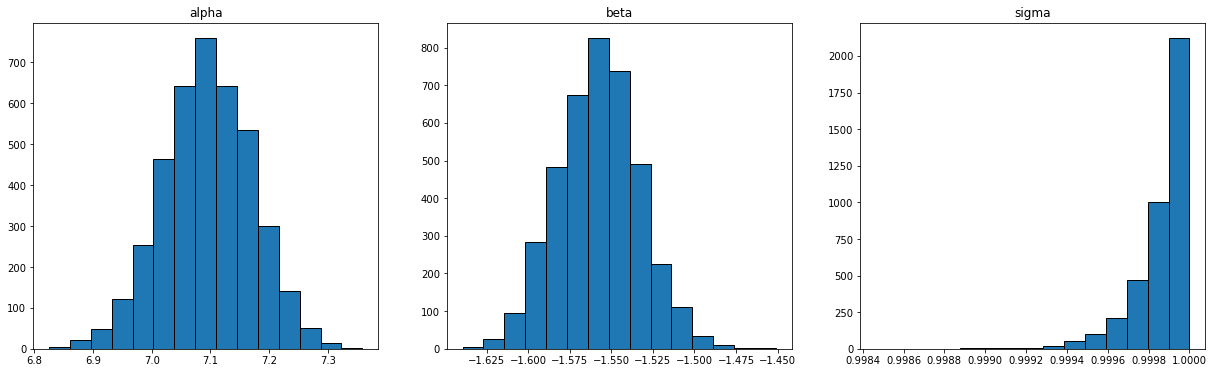

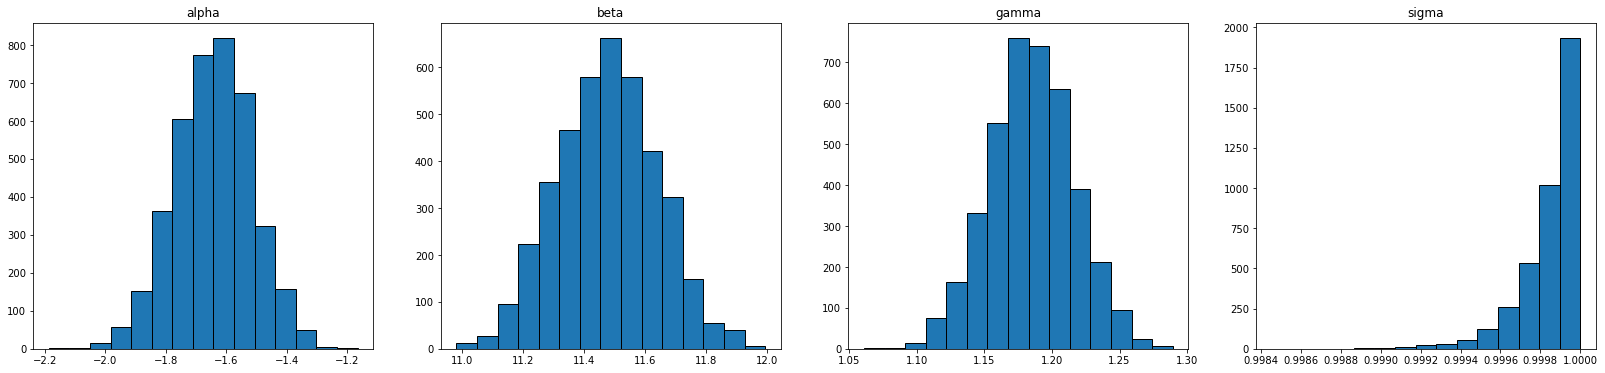

c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
c:\Users\Maciej\miniconda3\lib\site-packages\arviz\stats\stats.py:1527: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
arviz_fit2,0,-4497.299326,25.130764,0.000000,0.652287,533.062110,0.000000,False,log
arviz_fit1,1,-4876.023200,17.154239,378.723874,0.347713,603.292165,115.228619,False,log


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
arviz_fit2,0,-4497.508670,25.340108,0.000000,0.652286,533.108935,0.000000,True,log
arviz_fit1,1,-4876.058311,17.189350,378.549641,0.347714,603.301544,115.191364,True,log


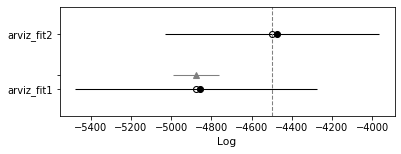

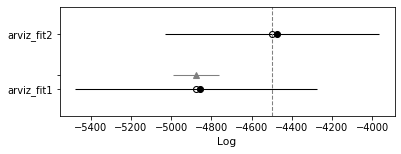

In [40]:
for data in country_and_fits:
    country, fit1, fit2 = data
    plot_results(country=country, fit1=fit1, fit2=fit2, span_start_idx=0, span=len(country[0]))